# Data Preparation & Analysis

## Process Overview

### 1. Data Collection
The dataset is publicly available at [Data.gov.sg](https://data.gov.sg/dataset/resale-flat-prices?resource_id=f1765b54-a209-4718-8d38-a39237f502b3), released by Singapore's House Development Board (HDB).

### 2. Data Discovery
Analysis is carried out to understanding the relationships and to reveal insights. In this task, visualization methods are important to help human digest the information at a glance, see major treads and outliers instantly, and enable decision making.

### 3. Data Cleansing
The errors and mistakes in the data is identified and corrected.

Errors might include:
- Data omission
- Data duplication
- Bad labels or values

### 4. Data Transform
Before applying machine learning algorithms, some variables must be encoded. Scaling of data might be needed if the algorithms to be used are based of distance of data points (eg. SVM, KNN).

---

## Analysis and cleansing of overall dataset
The dataset contains 124514 rows, each with 11 columns.

However, there are 252 duplicated rows (exclude the first occurance); after removal, there will be 124262 rows.

The target variable identified is 'resale_price', the data is imbalanced (not normally distributed and skewed towards left, more than 80% of data is below $600,000).

Therefore are 3489 instances (2.81%) are outlier.

In [3]:
# Read the dataset and identify variables
import pandas as pd
df = pd.read_csv('resale_flat_prices_based_on_registration_date_from_jan_2017_onwards.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124514 entries, 0 to 124513
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                124514 non-null  object 
 1   town                 124514 non-null  object 
 2   flat_type            124514 non-null  object 
 3   block                124514 non-null  object 
 4   street_name          124514 non-null  object 
 5   storey_range         124514 non-null  object 
 6   floor_area_sqm       124514 non-null  float64
 7   flat_model           124514 non-null  object 
 8   lease_commence_date  124514 non-null  int64  
 9   remaining_lease      124514 non-null  object 
 10  resale_price         124514 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 10.4+ MB


In [4]:
# Find the duplicated rows
df_duplicated = df[df.duplicated()]
df_duplicated.shape

(252, 11)

In [5]:
# Drop the duplicated rows
df = df.drop(df_duplicated.index, axis=0)
df.reset_index(inplace=True, drop=True)
df.shape

(124262, 11)

In [6]:
# Resample to 30,000 instances
from sklearn.utils import resample
df = resample(df, n_samples=30000, random_state=30)
df.reset_index(inplace=True, drop=True)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2018-11,BEDOK,3 ROOM,74,BEDOK NTH RD,04 TO 06,59.0,Improved,1978,58 years 03 months,245000.0
1,2020-05,BUKIT MERAH,5 ROOM,113,DEPOT RD,04 TO 06,119.0,Standard,1976,55 years 08 months,502000.0
2,2019-04,WOODLANDS,4 ROOM,202,MARSILING DR,04 TO 06,96.0,New Generation,1981,61 years 03 months,258000.0
3,2021-10,PUNGGOL,5 ROOM,669A,EDGEFIELD PLAINS,13 TO 15,112.0,Premium Apartment,2016,93 years 09 months,650000.0
4,2021-06,ANG MO KIO,4 ROOM,231,ANG MO KIO AVE 3,07 TO 09,92.0,New Generation,1977,55 years 04 months,392000.0


Text(0.5, 0, 'resale_price')

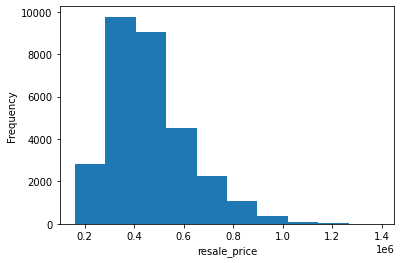

In [7]:
# Plot the histogram
df['resale_price'].plot(kind='hist')

import matplotlib.pyplot as plt
plt.xlabel('resale_price')

<AxesSubplot:>

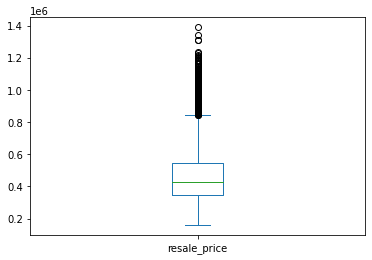

In [8]:
df['resale_price'].plot(kind='box')

From the box plot above, we can see there are many outliers at the upper bound (> IQR*1.5).

In [9]:
print('Target variable (resale_price)')

q1 = df['resale_price'].quantile(0.25)
q3 = df['resale_price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - iqr * 1.5
upper_bound = q3 + iqr * 1.5

print('Q1 =', q1)
print('Q3 =', q3)
print('IQR =', iqr)
print('Lower Bound =', lower_bound)
print('Upper Bound =', upper_bound)

import numpy as np
df_outlier = df[np.logical_or(df['resale_price'] < lower_bound, df['resale_price'] > upper_bound)]
print('Outlier count:', df_outlier['resale_price'].count())
print('Outlier %:', df_outlier['resale_price'].count() / df['resale_price'].count() * 100.0)

Target variable (resale_price)
Q1 = 345000.0
Q3 = 545000.0
IQR = 200000.0
Lower Bound = 45000.0
Upper Bound = 845000.0
Outlier count: 838
Outlier %: 2.7933333333333334


---

### Analysis, cleansing, and transformation on 'month' variable 
The value of 'month' column is identified as string with 'yyyy-MM' format.

The data is sorted as the month is in ascending order. Based on the analysis, the past trend is that month do not correlate linearly with resale_price, but in nearer term (after year 2021), the resale price shot up and in increasing trend.

Considering month is a continuous time period (ordinal), the variable should be transform as in first month, second month, ...

In [10]:
# Identify the values of 'month' column
df['month'].value_counts()

2021-01    670
2020-12    642
2022-01    640
2021-07    636
2021-11    618
          ... 
2018-02    286
2018-01    261
2017-02    257
2020-04    108
2020-05     89
Name: month, Length: 64, dtype: int64

In [11]:
# Convert from string to time series (PeriodIndex)
df['month'] = pd.PeriodIndex(data=df['month'], freq='M')

In [12]:
# Find the minimum month
min_month = df['month'].min()
min_month

Period('2017-01', 'M')

In [13]:
arr = []
for row in df['month']:
    # Calculate number of months since 2017-01
    y = row.year - min_month.year
    m = row.month - min_month.month
    arr.append(y * 12 + m)

import numpy as np
arr = np.array(arr)
print(arr)
df['month'] = pd.DataFrame(arr)

[22 40 27 ... 31 63 42]


<AxesSubplot:ylabel='Frequency'>

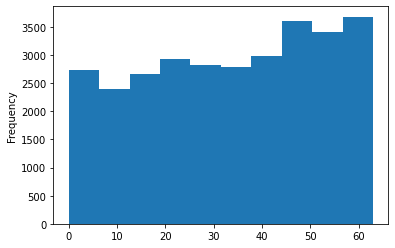

In [14]:
import matplotlib.pyplot as plt
df['month'].plot(kind='hist')

<AxesSubplot:>

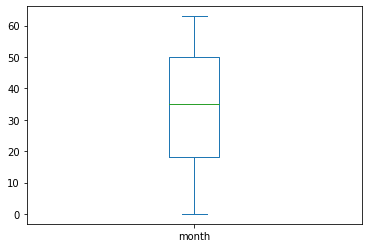

In [15]:
df['month'].plot(kind='box')

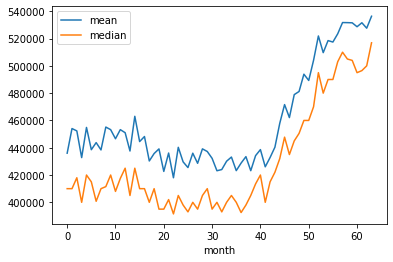

In [16]:
group = df.groupby('month')
group['resale_price'].mean().plot(label='mean')
group['resale_price'].median().plot(label='median')
plt.legend()

---

### Analysis, cleansing, and transformation on 'flat_type' variable
'flat_type' is categorical variable with implicit order, i.e. can be ordered by the number of room. The resale price increased with the higher number of room.

Therefore, there are two ways to encode the variable - one-hot encoder or label/ordinal encoder.

Ordinal label encoding is used here because the advantage of not increasing the dimension of data.

The distribution of the features is roughly normally distributed.

In [17]:
df['flat_type'].value_counts()

4 ROOM              12569
5 ROOM               7534
3 ROOM               7057
EXECUTIVE            2363
2 ROOM                457
MULTI-GENERATION       11
1 ROOM                  9
Name: flat_type, dtype: int64

In [18]:
group = df.groupby('flat_type')
group['resale_price'].describe()

,count,mean,std,min,25%,50%,75%,max
flat_type,,,,,,,,
1 ROOM,9.0,189000.000000,18384.776311,160000.0,180000.0,180000.0,205000.0,218000.00
2 ROOM,457.0,244588.698031,43499.053798,160000.0,218000.0,238000.0,260000.0,508000.00
3 ROOM,7057.0,321926.812270,79091.036415,174000.0,270500.0,308000.0,350000.0,1140000.00
4 ROOM,12569.0,457734.757807,125577.051062,225000.0,372000.0,428000.0,504000.0,1186888.00
5 ROOM,7534.0,556884.666828,150979.186677,275000.0,448000.0,520000.0,628000.0,1388888.88
EXECUTIVE,2363.0,653358.477253,125009.938947,390000.0,565000.0,635000.0,720000.0,1238000.00
MULTI-GENERATION,11.0,811989.818182,84506.025468,683888.0,744500.0,838000.0,849000.0,955000.00


In [19]:
# Calculate %
group['resale_price'].count() / df['resale_price'].count() * 100.

flat_type
1 ROOM               0.030000
2 ROOM               1.523333
3 ROOM              23.523333
4 ROOM              41.896667
5 ROOM              25.113333
EXECUTIVE            7.876667
MULTI-GENERATION     0.036667
Name: resale_price, dtype: float64

Text(0, 0.5, 'count')

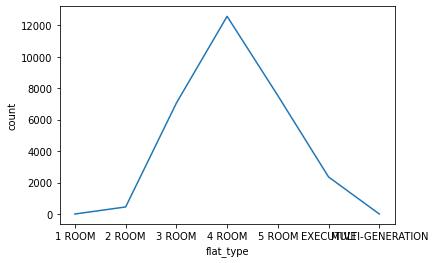

In [20]:
group['resale_price'].count().plot()
plt.xlabel('flat_type')
plt.ylabel('count')

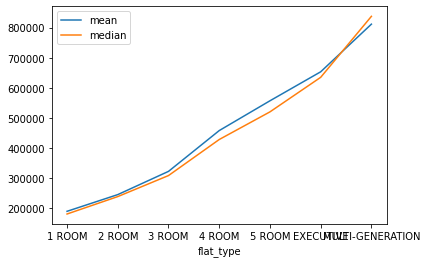

In [21]:
group['resale_price'].mean().plot(label='mean')
group['resale_price'].median().plot(label='median')
plt.legend()

In [22]:
# Order flat_type by median price
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.classes_ = group['resale_price'].median().sort_values().keys().to_numpy()
le.classes_

array(['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION'], dtype=object)

In [23]:
df['flat_type'] = le.transform(df['flat_type'])

In [24]:
df['flat_type'].value_counts()

3    12569
4     7534
2     7057
5     2363
1      457
6       11
0        9
Name: flat_type, dtype: int64

---

### Analysis, cleansing, and transformation on 'floor_area_sqm' variable
The variable is numerical continuous, and has positive correlation with resale price.

The distribution is quite similar to the distribution of target variable (resale_price), which might indicate the correlation might be high between them.

In [25]:
df['floor_area_sqm'].describe()

count    30000.000000
mean        97.668357
std         24.067867
min         31.000000
25%         82.000000
50%         94.000000
75%        113.000000
max        199.000000
Name: floor_area_sqm, dtype: float64

<AxesSubplot:ylabel='Frequency'>

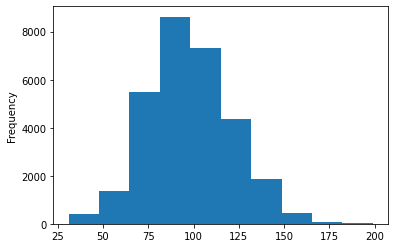

In [26]:
df['floor_area_sqm'].plot(kind='hist')

<AxesSubplot:>

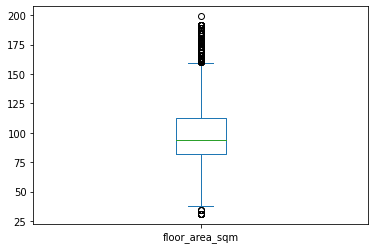

In [27]:
df['floor_area_sqm'].plot(kind='box')

In [28]:
print('Feature variable (floor_area_sqm)')

q1 = df['floor_area_sqm'].quantile(0.25)
q3 = df['floor_area_sqm'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - iqr * 1.5
upper_bound = q3 + iqr * 1.5

print('Q1 =', q1)
print('Q3 =', q3)
print('IQR =', iqr)
print('Lower Bound =', lower_bound)
print('Upper Bound =', upper_bound)

import numpy as np
df_outlier = df[np.logical_or(df['floor_area_sqm'] < lower_bound, df['floor_area_sqm'] > upper_bound)]
print('Outlier count:', df_outlier['floor_area_sqm'].count())
print('Outlier %:', df_outlier['floor_area_sqm'].count() / df['floor_area_sqm'].count() * 100.0)

Feature variable (floor_area_sqm)
Q1 = 82.0
Q3 = 113.0
IQR = 31.0
Lower Bound = 35.5
Upper Bound = 159.5
Outlier count: 178
Outlier %: 0.5933333333333333


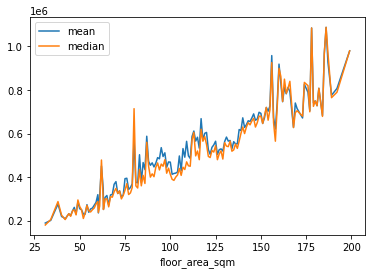

In [29]:
group = df.groupby('floor_area_sqm')
group['resale_price'].mean().plot(label='mean')
group['resale_price'].median().plot(label='median')
plt.legend()

---

### Analysis, cleansing, and transformation on 'storey_range' variable
The variable is ordinal categorical, and in the string format of 'MM to NN'. Since the number can be detected and ordered by a LabelEncoder automatically, the simpler label encoder is used.

The relationship trend indicate the higher the floor number, the higher resale price.

In [30]:
df['storey_range'].value_counts()

04 TO 06    7066
07 TO 09    6334
10 TO 12    5534
01 TO 03    5256
13 TO 15    2890
16 TO 18    1306
19 TO 21     583
22 TO 24     405
25 TO 27     230
28 TO 30     147
31 TO 33      68
37 TO 39      61
34 TO 36      60
40 TO 42      38
43 TO 45      11
46 TO 48       6
49 TO 51       5
Name: storey_range, dtype: int64

In [31]:
group = df.groupby('storey_range')
group['resale_price'].describe()

,count,mean,std,min,25%,50%,75%,max
storey_range,,,,,,,,
01 TO 03,5256.0,4.153053e+05,137649.381632,160000.0,315000.0,390000.0,488000.0,1140000.00
04 TO 06,7066.0,4.358468e+05,142594.113236,160000.0,330000.0,410000.0,515000.0,1238000.00
07 TO 09,6334.0,4.501393e+05,144688.506823,180000.0,340250.0,425000.0,530000.0,1202000.00
10 TO 12,5534.0,4.597481e+05,148592.003169,160000.0,350000.0,435000.0,538888.0,1128000.00
13 TO 15,2890.0,4.947559e+05,144141.555121,199000.0,398000.0,475000.0,574722.0,1210000.00
16 TO 18,1306.0,5.372858e+05,165196.251053,192000.0,420000.0,500000.0,637250.0,1140000.00
19 TO 21,583.0,6.091275e+05,188807.014035,210000.0,454400.0,595000.0,750000.0,1160000.00
22 TO 24,405.0,6.230247e+05,184214.595934,210000.0,465000.0,600000.0,765000.0,1200000.00
25 TO 27,230.0,6.876670e+05,185091.706553,260000.0,530000.0,699000.0,829500.0,1130000.00


Text(0, 0.5, 'count')

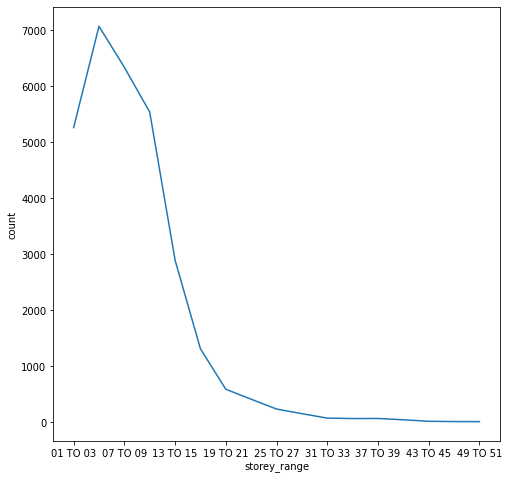

In [32]:
from matplotlib.pyplot import figure
figure(figsize=(8,8))
group['resale_price'].count().plot()
plt.xlabel('storey_range')
plt.ylabel('count')

In [33]:
group['resale_price'].count() / df['resale_price'].count() * 100.

storey_range
01 TO 03    17.520000
04 TO 06    23.553333
07 TO 09    21.113333
10 TO 12    18.446667
13 TO 15     9.633333
16 TO 18     4.353333
19 TO 21     1.943333
22 TO 24     1.350000
25 TO 27     0.766667
28 TO 30     0.490000
31 TO 33     0.226667
34 TO 36     0.200000
37 TO 39     0.203333
40 TO 42     0.126667
43 TO 45     0.036667
46 TO 48     0.020000
49 TO 51     0.016667
Name: resale_price, dtype: float64

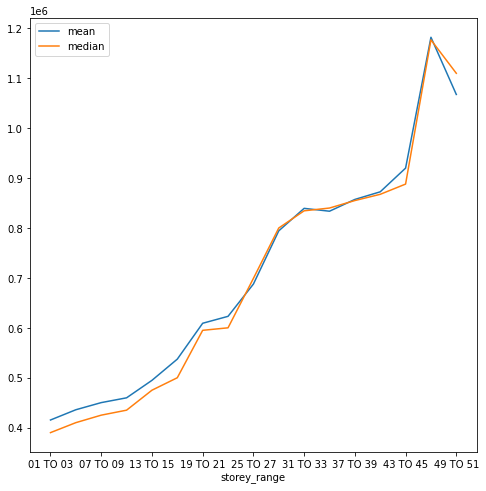

In [34]:
figure(figsize=(8,8))
group['resale_price'].mean().plot(label='mean')
group['resale_price'].median().plot(label='median')
plt.legend()

In [35]:
# Use fit_transform since the text is sorted
df['storey_range'] = le.fit_transform(df['storey_range'])
df['storey_range'].value_counts()

1     7066
2     6334
3     5534
0     5256
4     2890
5     1306
6      583
7      405
8      230
9      147
10      68
12      61
11      60
13      38
14      11
15       6
16       5
Name: storey_range, dtype: int64

---

### Analysis, cleansing, and transformation on 'remaining_lease' variable
This is a numerical variable but in string format of 'M years N months', therefore we convert all the values to number of months.

For the data distribution, there are significant high frequency of remaining_lease >= 1100 months, yet also unusual surged of resale price on these range. __Since the frequency is high, it is hard to say those are outliers, therefore need further investigation__.

In [36]:
df['remaining_lease'].head()

0    58 years 03 months
1    55 years 08 months
2    61 years 03 months
3    93 years 09 months
4    55 years 04 months
Name: remaining_lease, dtype: object

In [37]:
# The text contains diffrent whitespaces and
# inconsistent use of 'month'/'months'
# But, year value is always available

# Temporary array
arr = []

for i in range(len(df['remaining_lease'])):
    # Split by space
    strs = df['remaining_lease'][i].split()
    arr2 = [0, 0]
    j = 0
    for k in range(len(strs)):
        if (strs[k].isnumeric()):
            arr2[j] = int(strs[k])
            j += 1
            if j > 1:
                continue
    arr.append(arr2[0] * 12 + arr2[1])

arr = np.array(arr)
df['remaining_lease'] = pd.DataFrame(arr)
df['remaining_lease'].head()

0     699
1     668
2     735
3    1125
4     664
Name: remaining_lease, dtype: int32

In [38]:
df['remaining_lease'].describe()

count    30000.000000
mean       898.226833
std        161.127358
min        527.000000
25%        770.000000
50%        899.000000
75%       1026.000000
max       1161.000000
Name: remaining_lease, dtype: float64

Text(0, 0.5, 'count')

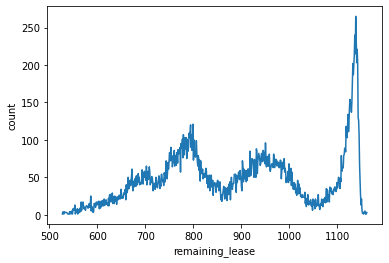

In [39]:
group = df.groupby('remaining_lease')
group['resale_price'].count().plot()
plt.xlabel('remaining_lease')
plt.ylabel('count')

<AxesSubplot:>

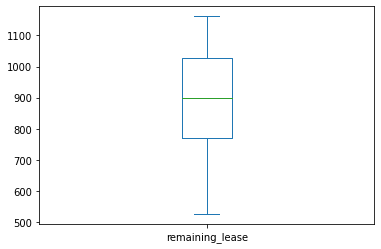

In [40]:
df['remaining_lease'].plot(kind='box')

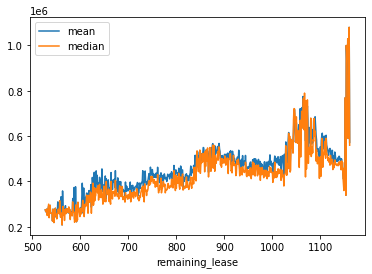

In [41]:
group = df.groupby('remaining_lease')
group['resale_price'].mean().plot(label='mean')
group['resale_price'].median().plot(label='median')
plt.legend()

---

### Analysis, cleansing, and transformation on 'lease_commence_date' variable
This column mean the year of the lease commenced, since the resale price data is the price on a particular month, the lease commence should indicate how old the house is.

Therefore, the variable can be transformed by substracting the year.

The resale price tends to be lower when the house is older.

In [42]:
df['lease_commence_date'].describe()

count    30000.000000
mean      1995.178500
std         13.498878
min       1966.000000
25%       1985.000000
50%       1996.000000
75%       2005.000000
max       2019.000000
Name: lease_commence_date, dtype: float64

In [43]:
df['lease_commence_date'] = df['month'] + (min_month.year - df['lease_commence_date']) * 12
df['lease_commence_date'].head()

0    490
1    532
2    459
3     69
4    533
Name: lease_commence_date, dtype: int64

<AxesSubplot:ylabel='Frequency'>

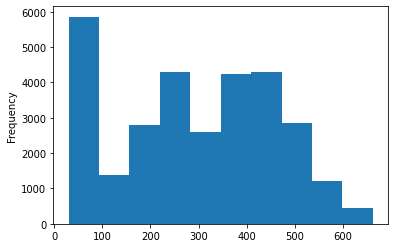

In [44]:
df['lease_commence_date'].plot(kind='hist')

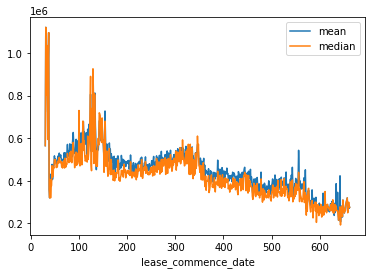

In [45]:
group = df.groupby('lease_commence_date')
group['resale_price'].mean().plot(label='mean')
group['resale_price'].median().plot(label='median')
plt.legend()

---

### Analysis, cleansing, and transformation on 'town' variable
The town variable should be meaningful if we combine with other data, such as distance to nearest public transpart, number of amenities, and etc.

An alternative method is categorize the town into singapore's region (urban planning subdivisions demarcated by URA Singapore). The five regions are North, East, North-East, Central, and West.

This will group the 'town' into five categories, and one-hot encoder can be used (encode into five columns).

In [46]:
df['town'].value_counts()

SENGKANG           2578
WOODLANDS          2158
PUNGGOL            2112
TAMPINES           2089
YISHUN             2055
JURONG WEST        1992
BEDOK              1567
HOUGANG            1474
CHOA CHU KANG      1359
ANG MO KIO         1202
BUKIT MERAH        1172
BUKIT PANJANG      1101
BUKIT BATOK        1023
TOA PAYOH           974
PASIR RIS           938
KALLANG/WHAMPOA     876
QUEENSTOWN          839
GEYLANG             716
SEMBAWANG           715
CLEMENTI            696
JURONG EAST         661
SERANGOON           613
BISHAN              603
CENTRAL AREA        225
MARINE PARADE       186
BUKIT TIMAH          76
Name: town, dtype: int64

In [47]:
group = df.groupby('town')
group['resale_price'].describe()

,count,mean,std,min,25%,50%,75%,max
town,,,,,,,,
ANG MO KIO,1202.0,424031.415141,176019.660927,174000.0,295000.0,360000.0,494750.0,1100000.00
BEDOK,1567.0,428371.911295,155827.866479,180000.0,305000.0,378000.0,540000.0,950000.00
BISHAN,603.0,645144.109453,187719.357101,210000.0,512000.0,608000.0,765833.0,1338888.00
BUKIT BATOK,1023.0,406657.228495,143041.773811,220000.0,286000.0,375000.0,500000.0,968000.00
BUKIT MERAH,1172.0,570127.191126,220729.267342,160000.0,350000.0,585000.0,755250.0,1130000.00
BUKIT PANJANG,1101.0,453612.422343,116696.875955,205000.0,365000.0,443000.0,525000.0,898000.00
BUKIT TIMAH,76.0,750377.157895,227450.908015,335000.0,616250.0,730000.0,885000.0,1238000.00
CENTRAL AREA,225.0,653940.981689,279211.784400,230000.0,430000.0,538000.0,920888.0,1388888.88
CHOA CHU KANG,1359.0,425142.441641,95878.284765,208000.0,350000.0,415000.0,488000.0,755000.00


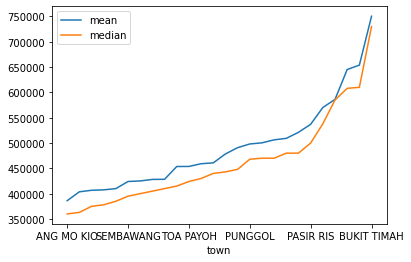

In [48]:
group = df.groupby('town')
group['resale_price'].mean().sort_values().plot(label='mean')
group['resale_price'].median().sort_values().plot(label='median')
plt.legend()

In [49]:
le.classes_ = group['resale_price'].mean().sort_values().keys().to_numpy()
le.classes_

array(['YISHUN', 'WOODLANDS', 'BUKIT BATOK', 'SEMBAWANG', 'JURONG WEST',
       'ANG MO KIO', 'CHOA CHU KANG', 'JURONG EAST', 'BEDOK',
       'BUKIT PANJANG', 'GEYLANG', 'HOUGANG', 'SENGKANG', 'PUNGGOL',
       'TAMPINES', 'TOA PAYOH', 'CLEMENTI', 'SERANGOON',
       'KALLANG/WHAMPOA', 'PASIR RIS', 'MARINE PARADE', 'BUKIT MERAH',
       'QUEENSTOWN', 'BISHAN', 'CENTRAL AREA', 'BUKIT TIMAH'],
      dtype=object)

In [50]:
central_region = ['GEYLANG','TOA PAYOH','KALLANG/WHAMPOA','MARINE PARADE', 'BUKIT MERAH', 'QUEENSTOWN', 'BISHAN', 'CENTRAL AREA', 'BUKIT TIMAH']
north_region = ['YISHUN', 'WOODLANDS', 'SEMBAWANG']
east_region = ['BEDOK', 'TAMPINES', 'PASIR RIS']
north_east_region = ['ANG MO KIO', 'HOUGANG', 'SENGKANG', 'PUNGGOL', 'SERANGOON']
west_region = ['BUKIT BATOK','JURONG WEST', 'CHOA CHU KANG', 'JURONG EAST', 'BUKIT PANJANG', 'CLEMENTI']

In [51]:
import numpy as np
df.loc[np.in1d(df['town'], central_region), 'region'] = 'central'
df.loc[np.in1d(df['town'], north_region), 'region'] = 'north'
df.loc[np.in1d(df['town'], east_region), 'region'] = 'east'
df.loc[np.in1d(df['town'], north_east_region), 'region'] = 'north_east'
df.loc[np.in1d(df['town'], west_region), 'region'] = 'west'

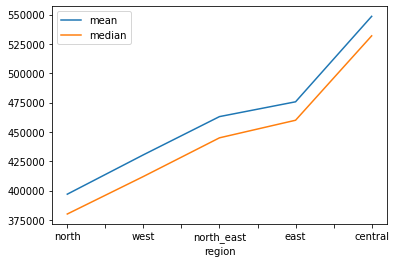

In [52]:
import matplotlib.pyplot as plt
group = df.groupby('region')
group['resale_price'].mean().sort_values().plot(label='mean')
group['resale_price'].median().sort_values().plot(label='median')
plt.legend()

Text(0, 0.5, 'count')

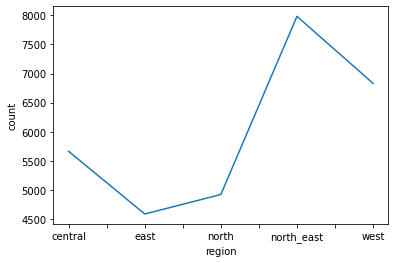

In [53]:
group = df.groupby('region')
group['resale_price'].count().plot()
plt.xlabel('region')
plt.ylabel('count')

In [54]:
group['resale_price'].count() / df['resale_price'].count() * 100.

region
central       18.890000
east          15.313333
north         16.426667
north_east    26.596667
west          22.773333
Name: resale_price, dtype: float64

In [55]:
df = pd.get_dummies(df, columns=['region'], prefix=['region'])

In [56]:
df.drop('town', axis=1, inplace=True)
df.head(3)

,month,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region_central,region_east,region_north,region_north_east,region_west
0,22,2,74,BEDOK NTH RD,1,59.0,Improved,490,699,245000.0,0,1,0,0,0
1,40,4,113,DEPOT RD,1,119.0,Standard,532,668,502000.0,1,0,0,0,0
2,27,3,202,MARSILING DR,1,96.0,New Generation,459,735,258000.0,0,0,1,0,0


---

### Analysis, cleansing, and transformation on 'flat_model' variable
The column means different flat model that was released in different year. Each model has different criteria which also has relationship with number of rooms and floor size.

If we don't have all the details, we may just drop the column OR transform it based on assumption.

There are also some model with very few instances, such as 2-ROOMS model.

In [57]:
df['flat_model'].value_counts()

Model A                   9988
Improved                  7466
New Generation            3850
Premium Apartment         3352
Apartment                 1230
Simplified                1198
Standard                   868
Maisonette                 867
DBSS                       569
Model A2                   371
Adjoined flat               58
Type S1                     52
Model A-Maisonette          46
Type S2                     28
Terrace                     20
Premium Apartment Loft      18
Multi Generation            11
2-room                       5
Improved-Maisonette          3
Name: flat_model, dtype: int64

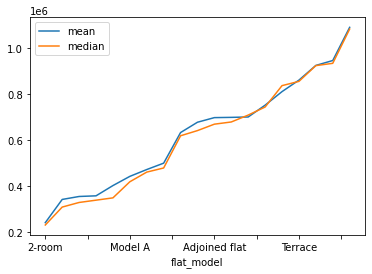

In [58]:
group = df.groupby('flat_model')
group['resale_price'].mean().sort_values().plot(label='mean')
group['resale_price'].median().sort_values().plot(label='median')
plt.legend()

Text(0, 0.5, 'count')

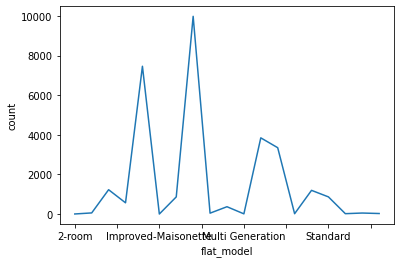

In [59]:
group['resale_price'].count().plot()
plt.xlabel('flat_model')
plt.ylabel('count')

In [60]:
group['resale_price'].count() / df['resale_price'].count() * 100.

flat_model
2-room                     0.016667
Adjoined flat              0.193333
Apartment                  4.100000
DBSS                       1.896667
Improved                  24.886667
Improved-Maisonette        0.010000
Maisonette                 2.890000
Model A                   33.293333
Model A-Maisonette         0.153333
Model A2                   1.236667
Multi Generation           0.036667
New Generation            12.833333
Premium Apartment         11.173333
Premium Apartment Loft     0.060000
Simplified                 3.993333
Standard                   2.893333
Terrace                    0.066667
Type S1                    0.173333
Type S2                    0.093333
Name: resale_price, dtype: float64

In [61]:
le.classes_ = group['resale_price'].mean().sort_values().keys().to_numpy()
le.classes_

array(['2-room', 'New Generation', 'Simplified', 'Model A2', 'Standard',
       'Model A', 'Improved', 'Premium Apartment', 'Apartment',
       'Model A-Maisonette', 'Adjoined flat', 'Improved-Maisonette',
       'Maisonette', 'DBSS', 'Multi Generation', 'Terrace',
       'Premium Apartment Loft', 'Type S1', 'Type S2'], dtype=object)

In [62]:
df['flat_model'] = le.transform(df['flat_model'])
df['flat_model'].value_counts()

5     9988
6     7466
1     3850
7     3352
8     1230
2     1198
4      868
12     867
13     569
3      371
10      58
17      52
9       46
18      28
15      20
16      18
14      11
0        5
11       3
Name: flat_model, dtype: int64

<AxesSubplot:xlabel='flat_model'>

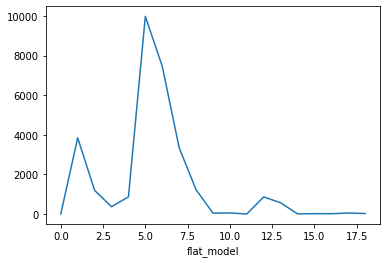

In [63]:
group = df.groupby('flat_model')
group['resale_price'].count().plot()

---

### Analysis, cleansing, and transformation on 'block' variable
The block number is hardly meaningful if no binding to exact location i.e. coordinate. This variable should be dropped.

With the visualization, there are hardly any correlation with the resale price.

In [64]:
# To verify, Extract number
arr = []
for i in range(len(df['block'])):
    arr.append(int(''.join([n for n in df['block'][i] if n.isdigit()])))
arr = np.array(arr)
df['block'] = pd.DataFrame(arr)

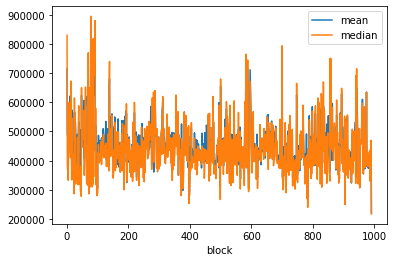

In [65]:
group = df.groupby('block')
group['resale_price'].mean().plot(label='mean')
group['resale_price'].median().plot(label='median')
plt.legend()

---

### Analysis, cleansing, and transformation on 'street_name' variable
The street name is also meaningful if we know the exact location. Other wise, it is related to the 'town' variable, for simplication, we will drop this column too.

In [66]:
df['street_name'].describe()

count              30000
unique               553
top       YISHUN RING RD
freq                 434
Name: street_name, dtype: object

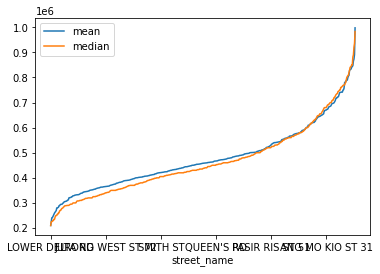

In [67]:
group = df.groupby('street_name')
group['resale_price'].mean().sort_values().plot(label='mean')
group['resale_price'].median().sort_values().plot(label='median')
plt.legend()

__Update:__ Since the town is grouped into region, we can drop the street_name together.

In [70]:
df.drop('street_name', axis=1, inplace=True)
df.head(3)

,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region_central,region_east,region_north,region_north_east,region_west
0,22,2,74,1,59.0,6,490,699,245000.0,0,1,0,0,0
1,40,4,113,1,119.0,4,532,668,502000.0,1,0,0,0,0
2,27,3,202,1,96.0,1,459,735,258000.0,0,0,1,0,0


---

## Overall Variable Correlation (after transform)

<AxesSubplot:>

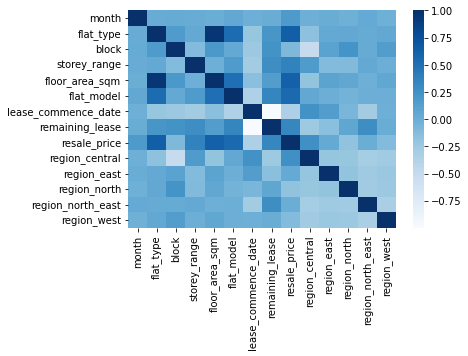

In [71]:
import seaborn as sb
sb.heatmap(df.corr(), cmap='Blues')

In [72]:
df.corr()

,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region_central,region_east,region_north,region_north_east,region_west
month,1.000000,0.016607,0.026794,0.019200,0.002579,0.048191,-0.012196,0.013903,0.172572,-0.013092,0.014746,-0.020185,0.031518,-0.015815
flat_type,0.016607,1.000000,0.167336,0.039638,0.951271,0.532958,-0.215777,0.216698,0.638148,-0.170291,0.039435,0.053197,0.024224,0.052560
block,0.026794,0.167336,1.000000,-0.111883,0.191579,0.045895,-0.238875,0.240555,-0.098204,-0.506869,0.102576,0.232168,0.028929,0.149414
storey_range,0.019200,0.039638,-0.111883,1.000000,-0.007929,0.168302,-0.278735,0.278094,0.367980,0.170301,-0.117007,-0.107987,0.039399,-0.004584
floor_area_sqm,0.002579,0.951271,0.191579,-0.007929,1.000000,0.513718,-0.150713,0.151942,0.622683,-0.191712,0.089475,0.056169,-0.015064,0.068352
flat_model,0.048191,0.532958,0.045895,0.168302,0.513718,1.000000,-0.345924,0.345513,0.557266,0.050213,-0.001182,-0.040127,-0.002883,-0.007362
lease_commence_date,-0.012196,-0.215777,-0.238875,-0.278735,-0.150713,-0.345924,1.000000,-0.999770,-0.335841,0.246944,0.153549,-0.071505,-0.275557,-0.008844
remaining_lease,0.013903,0.216698,0.240555,0.278094,0.151942,0.345513,-0.999770,1.000000,0.336210,-0.249088,-0.152196,0.070976,0.275222,0.010503
resale_price,0.172572,0.638148,-0.098204,0.367980,0.622683,0.557266,-0.335841,0.336210,1.000000,0.258544,0.034108,-0.182776,0.000776,-0.109940
region_central,-0.013092,-0.170291,-0.506869,0.170301,-0.191712,0.050213,0.246944,-0.249088,0.258544,1.000000,-0.205214,-0.213954,-0.290492,-0.262065


In [73]:
df.corr()['resale_price']

month                  0.172572
flat_type              0.638148
block                 -0.098204
storey_range           0.367980
floor_area_sqm         0.622683
flat_model             0.557266
lease_commence_date   -0.335841
remaining_lease        0.336210
resale_price           1.000000
region_central         0.258544
region_east            0.034108
region_north          -0.182776
region_north_east      0.000776
region_west           -0.109940
Name: resale_price, dtype: float64

The most correlated attribute can be seem from above.

Most:
- flat_type (categorical->ordinal)
- floor_area_sqm

(flat_type and floor_area_sqm are also highly correlated)


Second most:
- flat_model

(__we may want to drop flat_model and just using flat_type since we don't have enough information to order the flat_model__)

Third most:
- storey_range (categorical->ordinal)
- remaining_lease
- lease_commence_date

(remaining_lease and lease_commence_date are negative correlated)

In [74]:
df.head()

,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region_central,region_east,region_north,region_north_east,region_west
0,22,2,74,1,59.0,6,490,699,245000.0,0,1,0,0,0
1,40,4,113,1,119.0,4,532,668,502000.0,1,0,0,0,0
2,27,3,202,1,96.0,1,459,735,258000.0,0,0,1,0,0
3,57,4,669,4,112.0,7,69,1125,650000.0,0,0,0,1,0
4,53,3,231,2,92.0,1,533,664,392000.0,0,0,0,1,0


## Save data

In [75]:
df.to_csv('resale_flat_price_unscaled.csv', index=False)

---

## Summary

- The categorical variables are encoded, perferably using label encoder since it does not increase data dimension.
- Imbalanced (not natural distributed) data at target variables and most of the other features, __however, experiment needed to deal with these data since most existing methods are design for imbalanced categorical data (for classification)
- The only normal distributed feature is the number of year since lease commence.
- For 'flat_model' variable, further feature engineering might be needed, else we can only encode them using assumption.
- 'town' and 'street_name' variable can be grouped into 'region', and one-hot encoded.
- 'block number' and 'street_name' might be useful to determine exact location of particular house, else they will not be meaningful

All transformations:

__The dataset has been resampled to 30,000 instances.__

- 'month': From string, transformed into numeric ordinal
- 'town': Categorical string, grouped into 'region' and performed one-hot encoding
- 'flat_type': From categorical string, encoded to integer based on order of luxuriousness
- 'block': Numerical
- 'street_name': Categorical, dropped as records are grouped into 'region' already 
- 'storey_range': Already binned/grouped into categories of range, encoded to integer
- 'floor_area_sqm': Numerical continuous
- 'flat_model': From categorical string, encoded to integer (based on assumed order)
- 'lease_commence_data': From year, transformed into 'how many months since lease commence', numerical
- 'remaining_lease': From string, transformed into numerical 'number of months remained for the lease)

In [76]:
# Try reload from file to ensure the file is written correctly
df_temp = pd.read_csv('resale_flat_price_unscaled.csv')
df_temp.head()

,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region_central,region_east,region_north,region_north_east,region_west
0,22,2,74,1,59.0,6,490,699,245000.0,0,1,0,0,0
1,40,4,113,1,119.0,4,532,668,502000.0,1,0,0,0,0
2,27,3,202,1,96.0,1,459,735,258000.0,0,0,1,0,0
3,57,4,669,4,112.0,7,69,1125,650000.0,0,0,0,1,0
4,53,3,231,2,92.0,1,533,664,392000.0,0,0,0,1,0


--

## Further preprocessing:
Based on the experiment carried out at Experiment 1, the best result can be archieved by scaling the features variables using MinMaxScaler.

In [77]:
target = df_temp['resale_price']
features = df_temp.drop('resale_price', axis=1)

from sklearn.preprocessing import MinMaxScaler
features = pd.DataFrame(MinMaxScaler().fit_transform(features), columns=features.columns)

In [80]:
df_norm = pd.concat(
    [
        features['month'],
        features['flat_type'],
        features['block'],
        features['storey_range'],
        features['floor_area_sqm'],
        features['flat_model'],
        features['lease_commence_date'],
        features['remaining_lease'],
        pd.DataFrame(target, columns=['resale_price']),
        features['region_central'],
        features['region_east'],
        features['region_north'],
        features['region_north_east'],
        features['region_west']
    ], axis=1
)
df_norm.head()

,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region_central,region_east,region_north,region_north_east,region_west
0,0.349206,0.333333,0.073812,0.0625,0.166667,0.333333,0.727848,0.271293,245000.0,0.0,1.0,0.0,0.0,0.0
1,0.634921,0.666667,0.113246,0.0625,0.523810,0.222222,0.794304,0.222397,502000.0,1.0,0.0,0.0,0.0,0.0
2,0.428571,0.500000,0.203236,0.0625,0.386905,0.055556,0.678797,0.328076,258000.0,0.0,0.0,1.0,0.0,0.0
3,0.904762,0.666667,0.675430,0.2500,0.482143,0.388889,0.061709,0.943218,650000.0,0.0,0.0,0.0,1.0,0.0
4,0.841270,0.500000,0.232558,0.1250,0.363095,0.055556,0.795886,0.216088,392000.0,0.0,0.0,0.0,1.0,0.0


In [81]:
df_norm.to_csv('resale_flat_price_scaled.csv')

# Experiment 1: Analyzing Machine Learning Algorithms

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('resale_flat_price_unscaled_20220613.csv')

In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                30000 non-null  int64  
 1   flat_type            30000 non-null  int64  
 2   block                30000 non-null  int64  
 3   storey_range         30000 non-null  int64  
 4   floor_area_sqm       30000 non-null  float64
 5   flat_model           30000 non-null  int64  
 6   lease_commence_date  30000 non-null  int64  
 7   remaining_lease      30000 non-null  int64  
 8   resale_price         30000 non-null  float64
 9   region_central       30000 non-null  int64  
 10  region_east          30000 non-null  int64  
 11  region_north         30000 non-null  int64  
 12  region_north_east    30000 non-null  int64  
 13  region_west          30000 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 3.2 MB


In [5]:
target = df['resale_price']
features = df.drop('resale_price', axis =1)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(features)
scaled = scaler.fit_transform(features)
features_norm = pd.DataFrame(scaled, columns=features.columns)

In [7]:
features_norm.head()

,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,region_central,region_east,region_north,region_north_east,region_west
0,0.349206,0.333333,0.073812,0.0625,0.166667,0.333333,0.727848,0.271293,0.0,1.0,0.0,0.0,0.0
1,0.634921,0.666667,0.113246,0.0625,0.523810,0.222222,0.794304,0.222397,1.0,0.0,0.0,0.0,0.0
2,0.428571,0.500000,0.203236,0.0625,0.386905,0.055556,0.678797,0.328076,0.0,0.0,1.0,0.0,0.0
3,0.904762,0.666667,0.675430,0.2500,0.482143,0.388889,0.061709,0.943218,0.0,0.0,0.0,1.0,0.0
4,0.841270,0.500000,0.232558,0.1250,0.363095,0.055556,0.795886,0.216088,0.0,0.0,0.0,1.0,0.0


In [8]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
features_stand = pd.DataFrame(ss.fit_transform(features),columns = features.columns)
features_stand.head()

,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,region_central,region_east,region_north,region_north_east,region_west
0,-0.636883,-1.241495,-1.157374,-0.629983,-1.606665,0.259073,1.209851,-1.236476,-0.482591,2.351650,-0.443344,-0.601943,-0.543037
1,0.342823,0.930533,-1.002545,-0.629983,0.886327,-0.511556,1.471184,-1.428874,2.072150,-0.425233,-0.443344,-0.601943,-0.543037
2,-0.364743,-0.155481,-0.649217,-0.629983,-0.069320,-1.667500,1.016962,-1.013047,-0.482591,-0.425233,2.255585,-0.601943,-0.543037
3,1.268101,0.930533,1.204763,0.910234,0.595478,0.644387,-1.409700,1.407439,-0.482591,-0.425233,-0.443344,1.661286,-0.543037
4,1.050388,-0.155481,-0.534088,-0.116577,-0.235519,-1.667500,1.477406,-1.453699,-0.482591,-0.425233,-0.443344,1.661286,-0.543037


In [9]:
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(features, target, test_size = 0.2, random_state = 0)
x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size = 0.2, random_state =10)

In [10]:
from sklearn.model_selection import train_test_split
x_norm, x_test_norm, y_norm, y_test_norm = train_test_split(features_norm, target, test_size = 0.2, random_state = 0)
x_train_norm, x_dev_norm, y_train_norm, y_dev_norm = train_test_split(x_norm, y_norm, test_size = 0.2, random_state =10)

In [11]:
from sklearn.model_selection import train_test_split
x_stand, x_test_stand, y_stand, y_test_stand = train_test_split(features_stand, target, test_size = 0.2, random_state = 0)
x_train_stand, x_dev_stand, y_train_stand, y_dev_stand = train_test_split(x_stand, y_stand, test_size = 0.2, random_state =10)

# Normal dataset

In [33]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
K = []
scores = {}
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors= k, p =1)
    knn.fit(x_train, y_train)
    dev_predict = knn.predict(x_dev)
    validation_score = r2_score(y_dev, dev_predict)
    K.append(k)
    scores[k] = [validation_score]
for keys, values in scores.items():
    print("Validation score for k = ", keys, ":", values)

Validation score for k =  1 : [0.8339182852198861]
Validation score for k =  2 : [0.8455508014408588]
Validation score for k =  3 : [0.843106188360268]
Validation score for k =  4 : [0.8350379480377114]
Validation score for k =  5 : [0.8290490038259122]
Validation score for k =  6 : [0.8256137446999469]
Validation score for k =  7 : [0.8190349825074601]
Validation score for k =  8 : [0.81215268436478]
Validation score for k =  9 : [0.806408347102519]
Validation score for k =  10 : [0.8018186714013718]
Validation score for k =  11 : [0.7957478415146131]
Validation score for k =  12 : [0.7911209479714204]
Validation score for k =  13 : [0.7870002343169314]
Validation score for k =  14 : [0.7820054139303348]
Validation score for k =  15 : [0.7783760133365543]
Validation score for k =  16 : [0.7744909807580429]
Validation score for k =  17 : [0.7711698793460523]
Validation score for k =  18 : [0.7688587483764204]
Validation score for k =  19 : [0.7659228829105467]
Validation score for k = 

The best k is 2 for KNN (Manhattan)

In [34]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 2, p =1)
knn.fit(x_train, y_train)
dev_predict = knn.predict(x_dev)
print("MSE Manhattan (Validation) : ", metrics.mean_squared_error(y_dev, dev_predict))
print("RMSE Manhattan (Validation): ", sqrt(metrics.mean_squared_error(y_dev, dev_predict)))
print("MAE Manhattan (Validation): ", metrics.mean_absolute_error(y_dev, dev_predict))
print("R2 Manhattan (Validation): ", r2_score(y_dev, dev_predict))

MSE Manhattan (Validation) :  3896719305.794253
RMSE Manhattan (Validation):  62423.70788245643
MAE Manhattan (Validation):  39246.26155
R2 Manhattan (Validation):  0.8455508014408588


In [36]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 2, p =1)
knn.fit(x_train, y_train)
test_predict = knn.predict(x_test)
print("MSE Manhattan (Test) : ", metrics.mean_squared_error(y_test, test_predict))
print("RMSE Manhattan (Test): ", sqrt(metrics.mean_squared_error(y_test, test_predict)))
print("MAE Manhattan (Test): ", metrics.mean_absolute_error(y_test, test_predict))
print("R2 Manhattan (Test): ", r2_score(y_test, test_predict))

MSE Manhattan (Test) :  4292427370.6369143
RMSE Manhattan (Test):  65516.619041560094
MAE Manhattan (Test):  40921.501084999996
R2 Manhattan (Test):  0.8341029554542054


In [37]:
#Euclidean Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
K = []
scores = {}
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors= k, p =2)
    knn.fit(x_train, y_train)
    dev_predict = knn.predict(x_dev)
    validation_score = r2_score(y_dev, dev_predict)
    K.append(k)
    scores[k] = [validation_score]
for keys, values in scores.items():
    print("Validation score for k = ", keys, ":", values)

Validation score for k =  1 : [0.8236649602495283]
Validation score for k =  2 : [0.8346157835043235]
Validation score for k =  3 : [0.8308185684800575]
Validation score for k =  4 : [0.8259142657298931]
Validation score for k =  5 : [0.8167323987386013]
Validation score for k =  6 : [0.8085760577301541]
Validation score for k =  7 : [0.801701372461924]
Validation score for k =  8 : [0.7948140488921976]
Validation score for k =  9 : [0.7886442719931709]
Validation score for k =  10 : [0.7845211212602626]
Validation score for k =  11 : [0.7790194414463638]
Validation score for k =  12 : [0.7736838312089692]
Validation score for k =  13 : [0.7692235532183241]
Validation score for k =  14 : [0.7642605111307231]
Validation score for k =  15 : [0.7606145442599119]
Validation score for k =  16 : [0.7566468827440629]
Validation score for k =  17 : [0.751774080803439]
Validation score for k =  18 : [0.747000023684008]
Validation score for k =  19 : [0.7435482826784994]
Validation score for k =

The best k is 2 for KNN (Euclidean)

In [38]:
#Euclidean Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 2, p =2)
knn.fit(x_train, y_train)
dev_predict = knn.predict(x_dev)
print("MSE Euclidean (Validation) : ", metrics.mean_squared_error(y_dev, dev_predict))
print("RMSE Euclidean (Validation): ", sqrt(metrics.mean_squared_error(y_dev, dev_predict)))
print("MAE Euclidean (Validation): ", metrics.mean_absolute_error(y_dev, dev_predict))
print("R2 Euclidean (Validation): ", r2_score(y_dev, dev_predict))

MSE Euclidean (Validation) :  4172607402.981024
RMSE Euclidean (Validation):  64595.722791691274
MAE Euclidean (Validation):  40436.285299999996
R2 Euclidean (Validation):  0.8346157835043235


In [39]:
#Euclidean Distance
#Find the test score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 2, p =2)
knn.fit(x_train, y_train)
test_predict = knn.predict(x_test)
print("MSE Euclidean (Test) : ", metrics.mean_squared_error(y_test, test_predict))
print("RMSE Euclidean (Test): ", sqrt(metrics.mean_squared_error(y_test, test_predict)))
print("MAE Euclidean (Test): ", metrics.mean_absolute_error(y_test, test_predict))
print("R2 Euclidean (Test): ", r2_score(y_test, test_predict))

MSE Euclidean (Test) :  4615313794.648123
RMSE Euclidean (Test):  67936.10082016868
MAE Euclidean (Test):  42023.165835
R2 Euclidean (Test):  0.8216237918383347


In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
D = []
scores = {}
for d in range(1,21):
    DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = d, random_state = 0)
    DT.fit(x_train, y_train)
    dev_predict = DT.predict(x_dev)
    validation_score = r2_score(y_dev, dev_predict)
    D.append(d)
    scores[d] = [validation_score]
for keys, values in scores.items():
    print("Validation score for d = ", keys, ":", values)

Validation score for d =  1 : [0.2732669927276553]
Validation score for d =  2 : [0.4413212995994029]
Validation score for d =  3 : [0.6020609309167084]
Validation score for d =  4 : [0.6892756505424886]
Validation score for d =  5 : [0.7637085935090847]
Validation score for d =  6 : [0.7996343216157866]
Validation score for d =  7 : [0.820040136368804]
Validation score for d =  8 : [0.8361963359953056]
Validation score for d =  9 : [0.8490982919954775]
Validation score for d =  10 : [0.8578038695464789]
Validation score for d =  11 : [0.8660698521570094]
Validation score for d =  12 : [0.8738183588329067]
Validation score for d =  13 : [0.876583606160191]
Validation score for d =  14 : [0.8713883336241921]
Validation score for d =  15 : [0.8738486198447871]
Validation score for d =  16 : [0.8750413538554224]
Validation score for d =  17 : [0.8731459563356254]
Validation score for d =  18 : [0.8720365641409568]
Validation score for d =  19 : [0.8692608337562392]
Validation score for d 

The best d for Decision tree (square mean error) is 16

In [44]:
#Decision tree
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 16, random_state = 0)
DT.fit(x_train, y_train)
dev_predict = DT.predict(x_dev)
print("MSE DT sqaure error (Validation) : ", metrics.mean_squared_error(y_dev, dev_predict))
print("RMSE DT sqaure error (Validation): ", sqrt(metrics.mean_squared_error(y_dev, dev_predict)))
print("MAE DT sqaure error (Validation): ", metrics.mean_absolute_error(y_dev, dev_predict))
print("R2 DT sqaure error (Validation): ", r2_score(y_dev, dev_predict))

MSE DT sqaure error (Validation) :  3152679155.3472195
RMSE DT sqaure error (Validation):  56148.723541566105
MAE DT sqaure error (Validation):  35471.676742107724
R2 DT sqaure error (Validation):  0.8750413538554224


In [45]:
#Decision tree
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 16, random_state = 0)
DT.fit(x_train, y_train)
test_predict = DT.predict(x_test)
print("MSE DT sqaure error (Test) : ", metrics.mean_squared_error(y_test, test_predict))
print("RMSE DT sqaure error (Test): ", sqrt(metrics.mean_squared_error(y_test, test_predict)))
print("MAE DT sqaure error (Test): ", metrics.mean_absolute_error(y_test, test_predict))
print("R2 DT sqaure error (Test): ", r2_score(y_test, test_predict))

MSE DT sqaure error (Test) :  3472733666.1055665
RMSE DT sqaure error (Test):  58929.90468434143
MAE DT sqaure error (Test):  36778.44705331084
R2 DT sqaure error (Test):  0.8657831101249103


In [43]:
from sklearn.tree import DecisionTreeRegressor
D = []
scores = {}
for d in range(1,21):
    DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = d, random_state = 0)
    DT.fit(x_train, y_train)
    dev_predict = DT.predict(x_dev)
    validation_score = r2_score(y_dev, dev_predict)
    D.append(d)
    scores[d] = [validation_score]
for keys, values in scores.items():
    print("Validation score for d = ", keys, ":", values)

Validation score for d =  1 : [0.23184171572678514]
Validation score for d =  2 : [0.42273874999301697]
Validation score for d =  3 : [0.5856954617706092]
Validation score for d =  4 : [0.6736784654935251]
Validation score for d =  5 : [0.7471450282159855]
Validation score for d =  6 : [0.7849607661289997]
Validation score for d =  7 : [0.8123900307889864]
Validation score for d =  8 : [0.8320538472970538]
Validation score for d =  9 : [0.8401786163403407]
Validation score for d =  10 : [0.8525728404853379]
Validation score for d =  11 : [0.8615205918205155]
Validation score for d =  12 : [0.8681537729267801]
Validation score for d =  13 : [0.8758662871000794]
Validation score for d =  14 : [0.8790839184268595]
Validation score for d =  15 : [0.8864643807041935]
Validation score for d =  16 : [0.8809513236565769]
Validation score for d =  17 : [0.8818338432503484]
Validation score for d =  18 : [0.8833408374584878]
Validation score for d =  19 : [0.8832001940607046]
Validation score fo

The best d for Decision tree (absolute error) is 17

In [46]:
#Decision tree
#Find the validation score
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 17, random_state = 0)
DT.fit(x_train, y_train)
dev_predict = DT.predict(x_dev)
print("MSE DT (Validation) : ", metrics.mean_squared_error(y_dev, dev_predict))
print("RMSE DT (Validation): ", sqrt(metrics.mean_squared_error(y_dev, dev_predict)))
print("MAE DT (Validation): ", metrics.mean_absolute_error(y_dev, dev_predict))
print("R2 DT (Validation): ", r2_score(y_dev, dev_predict))

MSE DT (Validation) :  2981306142.0422916
RMSE DT (Validation):  54601.338280689524
MAE DT (Validation):  33457.20145833334
R2 DT (Validation):  0.8818338432503484


In [47]:
#Decision tree
#Find the validation score
# Import matplotlib library
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 17, random_state = 0)
DT.fit(x_train, y_train)
test_predict = DT.predict(x_test)
print("MSE DT (Test) : ", metrics.mean_squared_error(y_test, test_predict))
print("RMSE DT (Test): ", sqrt(metrics.mean_squared_error(y_test, test_predict)))
print("MAE DT (Test): ", metrics.mean_absolute_error(y_test, test_predict))
print("R2 DT (Test): ", r2_score(y_test, test_predict))

MSE DT (Test) :  3306635069.0370436
RMSE DT (Test):  57503.348328919456
MAE DT (Test):  34679.93807166667
R2 DT (Test):  0.8722026168462976


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
from math import sqrt
from sklearn.metrics import r2_score
lm = LinearRegression()
lm.fit(x_train, y_train)
dev_predict = lm.predict(x_dev)
print("MSE DT (Validation) : ", metrics.mean_squared_error(y_dev, dev_predict))
print("RMSE DT (Validation): ", sqrt(metrics.mean_squared_error(y_dev, dev_predict)))
print("MAE DT (Validation): ", metrics.mean_absolute_error(y_dev, dev_predict))
print("R2 DT (Validation): ", r2_score(y_dev, dev_predict))

MSE DT (Validation) :  6170314210.7891655
RMSE DT (Validation):  78551.34760644891
MAE DT (Validation):  61010.39941302452
R2 DT (Validation):  0.7554352751820238


In [15]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train, y_train)
test_predict = lm.predict(x_test)
print("MSE DT (Test) : ", metrics.mean_squared_error(y_test, test_predict))
print("RMSE DT (Test): ", sqrt(metrics.mean_squared_error(y_test, test_predict)))
print("MAE DT (Test): ", metrics.mean_absolute_error(y_test, test_predict))
print("R2 DT (Test): ", r2_score(y_test, test_predict))

MSE DT (Test) :  6277389459.720008
RMSE DT (Test):  79229.97828928144
MAE DT (Test):  61666.21898856848
R2 DT (Test):  0.7573866092751274


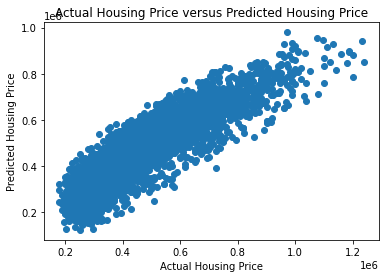

In [16]:
# Import matplotlib library
import matplotlib.pyplot as plt
plt.scatter(y_test, test_predict)
plt.xlabel('Actual Housing Price')
plt.ylabel('Predicted Housing Price')
plt.title('Actual Housing Price versus Predicted Housing Price')
plt.show()

# Normalized Dataset

In [50]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
K = []
scores = {}
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors= k, p =1)
    knn.fit(x_train_norm, y_train_norm)
    dev_predict = knn.predict(x_dev_norm)
    validation_score = r2_score(y_dev_norm, dev_predict)
    K.append(k)
    scores[k] = [validation_score]
for keys, values in scores.items():
    print("Validation score for k = ", keys, ":", values)

Validation score for k =  1 : [0.8936106729776313]
Validation score for k =  2 : [0.9046700600054776]
Validation score for k =  3 : [0.9093401345410337]
Validation score for k =  4 : [0.9084709530316708]
Validation score for k =  5 : [0.9076436887584907]
Validation score for k =  6 : [0.9049036025121564]
Validation score for k =  7 : [0.9029406692149272]
Validation score for k =  8 : [0.901672745516686]
Validation score for k =  9 : [0.8999950073945799]
Validation score for k =  10 : [0.898413016641769]
Validation score for k =  11 : [0.897078231644816]
Validation score for k =  12 : [0.8964603896075332]
Validation score for k =  13 : [0.8946200088965004]
Validation score for k =  14 : [0.8934504435829701]
Validation score for k =  15 : [0.8922566718449942]
Validation score for k =  16 : [0.8910081351967306]
Validation score for k =  17 : [0.8897075622883565]
Validation score for k =  18 : [0.8881126899544194]
Validation score for k =  19 : [0.8866905390371436]
Validation score for k =

The best k is 3 for KNN_norm (Manhattan)

In [55]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 3, p =1)
knn.fit(x_train_norm, y_train_norm)
dev_predict = knn.predict(x_dev_norm)
print("MSE Manhattan_Norm (Validation) : ", metrics.mean_squared_error(y_dev_norm, dev_predict))
print("RMSE Manhattan_Norm (Validation): ", sqrt(metrics.mean_squared_error(y_dev_norm, dev_predict)))
print("MAE Manhattan_Norm (Validation): ", metrics.mean_absolute_error(y_dev_norm, dev_predict))
print("R2 Manhattan_Norm (Validation): ", r2_score(y_dev_norm, dev_predict))

MSE Manhattan_Norm (Validation) :  2287328463.2771215
RMSE Manhattan_Norm (Validation):  47826.0228670242
MAE Manhattan_Norm (Validation):  32121.39132777778
R2 Manhattan_Norm (Validation):  0.9093401345410337


In [56]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 3, p =1)
knn.fit(x_train_norm, y_train_norm)
test_predict = knn.predict(x_test_norm)
print("MSE Manhattan_Norm (Test) : ", metrics.mean_squared_error(y_test_norm, test_predict))
print("RMSE Manhattan_Norm (Test): ", sqrt(metrics.mean_squared_error(y_test_norm, test_predict)))
print("MAE Manhattan_Norm (Test): ", metrics.mean_absolute_error(y_test_norm, test_predict))
print("R2 Manhattan_Norm (Test): ", r2_score(y_test_norm, test_predict))

MSE Manhattan_Norm (Test) :  2444483522.637057
RMSE Manhattan_Norm (Test):  49441.718443406244
MAE Manhattan_Norm (Test):  32302.826844444444
R2 Manhattan_Norm (Test):  0.9055237149449527


In [53]:
#Euclidean Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
K = []
scores = {}
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors= k, p =2)
    knn.fit(x_train_norm, y_train_norm)
    dev_predict = knn.predict(x_dev_norm)
    validation_score = r2_score(y_dev_norm, dev_predict)
    K.append(k)
    scores[k] = [validation_score]
for keys, values in scores.items():
    print("Validation score for k = ", keys, ":", values)

Validation score for k =  1 : [0.8796729132511969]
Validation score for k =  2 : [0.8892176845129018]
Validation score for k =  3 : [0.8944537017900497]
Validation score for k =  4 : [0.8952558454851509]
Validation score for k =  5 : [0.8945641602026674]
Validation score for k =  6 : [0.8919501862014094]
Validation score for k =  7 : [0.8900680532674139]
Validation score for k =  8 : [0.8886237865929024]
Validation score for k =  9 : [0.8874300923498679]
Validation score for k =  10 : [0.8859665134907388]
Validation score for k =  11 : [0.8838942936435052]
Validation score for k =  12 : [0.8825407811932435]
Validation score for k =  13 : [0.8812696072216755]
Validation score for k =  14 : [0.8798808495522238]
Validation score for k =  15 : [0.8779431195940909]
Validation score for k =  16 : [0.8758836862754779]
Validation score for k =  17 : [0.8742617512471774]
Validation score for k =  18 : [0.8727346973863824]
Validation score for k =  19 : [0.8714711730184115]
Validation score for 

The best k is 4 for KNN_norm (Euclidean)

In [57]:
#Euclidean Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 4, p =2)
knn.fit(x_train_norm, y_train_norm)
dev_predict = knn.predict(x_dev_norm)
print("MSE Euclidean (Validation) : ", metrics.mean_squared_error(y_dev_norm, dev_predict))
print("RMSE Euclidean (Validation): ", sqrt(metrics.mean_squared_error(y_dev_norm, dev_predict)))
print("MAE Euclidean (Validation): ", metrics.mean_absolute_error(y_dev_norm, dev_predict))
print("R2 Euclidean (Validation): ", r2_score(y_dev_norm, dev_predict))

MSE Euclidean (Validation) :  2642671978.0667405
RMSE Euclidean (Validation):  51406.92539013339
MAE Euclidean (Validation):  34479.911620833336
R2 Euclidean (Validation):  0.8952558454851509


In [58]:
#Euclidean Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 6, p =2)
knn.fit(x_train_norm, y_train_norm)
test_predict = knn.predict(x_test_norm)
print("MSE Euclidean (Test) : ", metrics.mean_squared_error(y_test_norm, test_predict))
print("RMSE Euclidean (Test): ", sqrt(metrics.mean_squared_error(y_test_norm, test_predict)))
print("MAE Euclidean (Test): ", metrics.mean_absolute_error(y_test_norm, test_predict))
print("R2 Euclidean (Test): ", r2_score(y_test_norm, test_predict))

MSE Euclidean (Test) :  2870466952.032702
RMSE Euclidean (Test):  53576.73890815586
MAE Euclidean (Test):  35601.210007500005
R2 Euclidean (Test):  0.8890599787276212


In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
D = []
scores = {}
for d in range(1,21):
    DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = d, random_state = 0)
    DT.fit(x_train_norm, y_train_norm)
    dev_predict = DT.predict(x_dev_norm)
    validation_score = r2_score(y_dev_norm, dev_predict)
    D.append(d)
    scores[d] = [validation_score]
for keys, values in scores.items():
    print("Validation score for d = ", keys, ":", values)

Validation score for d =  1 : [0.2732669927276553]
Validation score for d =  2 : [0.4413212995994029]
Validation score for d =  3 : [0.6020609309167084]
Validation score for d =  4 : [0.6892756505424886]
Validation score for d =  5 : [0.7637085935090847]
Validation score for d =  6 : [0.7996343216157866]
Validation score for d =  7 : [0.820040136368804]
Validation score for d =  8 : [0.8368767471009939]
Validation score for d =  9 : [0.8502904621119061]
Validation score for d =  10 : [0.858517064181263]
Validation score for d =  11 : [0.8664139673808557]
Validation score for d =  12 : [0.8757244016250301]
Validation score for d =  13 : [0.8787680837671765]
Validation score for d =  14 : [0.8732470868281672]
Validation score for d =  15 : [0.8747122945106898]
Validation score for d =  16 : [0.8759602771898453]
Validation score for d =  17 : [0.8744812569069367]
Validation score for d =  18 : [0.873572016836796]
Validation score for d =  19 : [0.8695206769250403]
Validation score for d =

The best d is 16 for DT_norm (square error)

In [60]:
#Decision tree
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 16, random_state = 0)
DT.fit(x_train_norm, y_train_norm)
dev_predict = DT.predict(x_dev_norm)
print("MSE DT_norm sqaure error (Validation) : ", metrics.mean_squared_error(y_dev_norm, dev_predict))
print("RMSE DT_norm sqaure error (Validation): ", sqrt(metrics.mean_squared_error(y_dev_norm, dev_predict)))
print("MAE DT_norm sqaure error (Validation): ", metrics.mean_absolute_error(y_dev_norm, dev_predict))
print("R2 DT_norm sqaure error (Validation): ", r2_score(y_dev_norm, dev_predict))

MSE DT_norm sqaure error (Validation) :  3129494921.7532887
RMSE DT_norm sqaure error (Validation):  55941.88879322264
MAE DT_norm sqaure error (Validation):  35406.05864025588
R2 DT_norm sqaure error (Validation):  0.8759602771898453


In [61]:
#Decision tree
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 16, random_state = 0)
DT.fit(x_train_norm, y_train_norm)
test_predict = DT.predict(x_test_norm)
print("MSE DT_norm sqaure error (Test) : ", metrics.mean_squared_error(y_test_norm, test_predict))
print("RMSE DT_norm sqaure error (Test): ", sqrt(metrics.mean_squared_error(y_test_norm, test_predict)))
print("MAE DT_norm sqaure error (Test): ", metrics.mean_absolute_error(y_test_norm, test_predict))
print("R2 DT_norm sqaure error (Test): ", r2_score(y_test_norm, test_predict))

MSE DT_norm sqaure error (Test) :  3444320764.9159403
RMSE DT_norm sqaure error (Test):  58688.33585062657
MAE DT_norm sqaure error (Test):  36684.474427670655
R2 DT_norm sqaure error (Test):  0.8668812338500954


In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
D = []
scores = {}
for d in range(1,21):
    DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = d, random_state = 0)
    DT.fit(x_train_norm, y_train_norm)
    dev_predict = DT.predict(x_dev_norm)
    validation_score = r2_score(y_dev_norm, dev_predict)
    D.append(d)
    scores[d] = [validation_score]
for keys, values in scores.items():
    print("Validation score for d = ", keys, ":", values)

Validation score for d =  1 : [0.23184171572678514]
Validation score for d =  2 : [0.42273874999301697]
Validation score for d =  3 : [0.5856954617706092]
Validation score for d =  4 : [0.6736784654935251]
Validation score for d =  5 : [0.7471450282159855]
Validation score for d =  6 : [0.7849607661289997]
Validation score for d =  7 : [0.812383713849251]
Validation score for d =  8 : [0.8320491901022685]
Validation score for d =  9 : [0.8401916218045018]
Validation score for d =  10 : [0.8531839899542195]
Validation score for d =  11 : [0.8615081127679991]
Validation score for d =  12 : [0.8701670929813692]
Validation score for d =  13 : [0.8763007486361167]
Validation score for d =  14 : [0.8788875266456518]
Validation score for d =  15 : [0.8857539233895452]
Validation score for d =  16 : [0.8806473183378537]
Validation score for d =  17 : [0.8817753925938312]
Validation score for d =  18 : [0.8833419067230619]
Validation score for d =  19 : [0.8834893622654951]
Validation score for

The best d for Decision tree (absolute error) is 15

In [16]:
#Decision tree
#Find the validation score
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 15, random_state = 0)
DT.fit(x_train_norm, y_train_norm)
test_predict = DT.predict(x_test_norm)
print("MSE DT_norm absolute error (Test) : ", metrics.mean_squared_error(y_test_norm, test_predict))
print("RMSE DT_norm absolute error (Test): ", sqrt(metrics.mean_squared_error(y_test_norm, test_predict)))
print("MAE DT_norm absolute error (Test): ", metrics.mean_absolute_error(y_test_norm, test_predict))
print("R2 DT_norm absolute error (Test): ", r2_score(y_test_norm, test_predict))

MSE DT_norm absolute error (Test) :  3238904337.1727934
RMSE DT_norm absolute error (Test):  56911.37265233367
MAE DT_norm absolute error (Test):  35132.44873833333
R2 DT_norm absolute error (Test):  0.8748203264243481


In [17]:
#Decision tree
#Find the test score
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 17, random_state = 0)
DT.fit(x_train_norm, y_train_norm)
dev_predict = DT.predict(x_dev_norm)
print("MSE DT_norm absolute error (Validation) : ", metrics.mean_squared_error(y_dev_norm, dev_predict))
print("RMSE DT_norm absolute error (Validation): ", sqrt(metrics.mean_squared_error(y_dev_norm, dev_predict)))
print("MAE DT_norm absolute error (Validation): ", metrics.mean_absolute_error(y_dev_norm, dev_predict))
print("R2 DT_norm absolute error (Validation): ", r2_score(y_dev_norm, dev_predict))

MSE DT_norm absolute error (Validation) :  2982780839.248958
RMSE DT_norm absolute error (Validation):  54614.84083332073
MAE DT_norm absolute error (Validation):  33505.08604166667
R2 DT_norm absolute error (Validation):  0.8817753925938312


In [17]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train_norm, y_train_norm)
dev_predict = lm.predict(x_dev_norm)
print("MSE DT_norm LM (Validation) : ", metrics.mean_squared_error(y_dev_norm, dev_predict))
print("RMSE DT_norm LM (Validation): ", sqrt(metrics.mean_squared_error(y_dev_norm, dev_predict)))
print("MAE DT_norm LM (Validation): ", metrics.mean_absolute_error(y_dev_norm, dev_predict))
print("R2 DT_norm LM (Validation): ", r2_score(y_dev_norm, dev_predict))

MSE DT_norm LM (Validation) :  6170314210.7891655
RMSE DT_norm LM (Validation):  78551.34760644891
MAE DT_norm LM (Validation):  61010.399413024636
R2 DT_norm LM (Validation):  0.7554352751820238


In [18]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train_norm, y_train_norm)
test_predict = lm.predict(x_test_norm)
print("MSE DT_norm LM (Test) : ", metrics.mean_squared_error(y_test_norm, test_predict))
print("RMSE DT_norm LM (Test): ", sqrt(metrics.mean_squared_error(y_test_norm, test_predict)))
print("MAE DT_norm LM (Test): ", metrics.mean_absolute_error(y_test_norm, test_predict))
print("R2 DT_norm LM (Test): ", r2_score(y_test_norm, test_predict))

MSE DT_norm LM (Test) :  6277389459.720008
RMSE DT_norm LM (Test):  79229.97828928144
MAE DT_norm LM (Test):  61666.218988568595
R2 DT_norm LM (Test):  0.7573866092751274


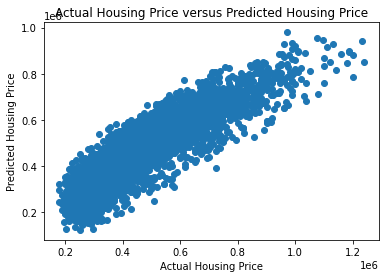

In [19]:
# Import matplotlib library
import matplotlib.pyplot as plt
plt.scatter(y_test_norm, test_predict)
plt.xlabel('Actual Housing Price')
plt.ylabel('Predicted Housing Price')
plt.title('Actual Housing Price versus Predicted Housing Price')
plt.show()

# Standardized Dataset

In [21]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
K = []
scores = {}
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors= k, p =1)
    knn.fit(x_train_stand, y_train_stand)
    dev_predict = knn.predict(x_dev_stand)
    validation_score = r2_score(y_dev_stand, dev_predict)
    K.append(k)
    scores[k] = [validation_score]
for keys, values in scores.items():
    print("Validation score for k = ", keys, ":", values)

Validation score for k =  1 : [0.884628989970879]
Validation score for k =  2 : [0.9005541739056717]
Validation score for k =  3 : [0.9048688693971736]
Validation score for k =  4 : [0.9071507436682129]
Validation score for k =  5 : [0.9058896303698463]
Validation score for k =  6 : [0.9046229221641637]
Validation score for k =  7 : [0.9030610614223314]
Validation score for k =  8 : [0.9022562566616645]
Validation score for k =  9 : [0.9010436446358104]
Validation score for k =  10 : [0.8995965619399536]
Validation score for k =  11 : [0.8977406694825949]
Validation score for k =  12 : [0.8964172491460298]
Validation score for k =  13 : [0.8949502437282466]
Validation score for k =  14 : [0.8937757842750929]
Validation score for k =  15 : [0.8931636323902846]
Validation score for k =  16 : [0.8920362948548577]
Validation score for k =  17 : [0.890983223482699]
Validation score for k =  18 : [0.8897639240013212]
Validation score for k =  19 : [0.8884547402320379]
Validation score for k 

The best k is 4 for KNN_stand (Manhattan)

In [25]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 4, p =1)
knn.fit(x_train_stand, y_train_stand)
dev_predict = knn.predict(x_dev_stand)
print("MSE Manhattan_Stand (Validation) : ", metrics.mean_squared_error(y_dev_stand, dev_predict))
print("RMSE Manhattan_Stand (Validation): ", sqrt(metrics.mean_squared_error(y_dev_stand, dev_predict)))
print("MAE Manhattan_Stand (Validation): ", metrics.mean_absolute_error(y_dev_stand, dev_predict))
print("R2 Manhattan_Stand (Validation): ", r2_score(y_dev_stand, dev_predict))

MSE Manhattan_Stand (Validation) :  2342566313.402861
RMSE Manhattan_Stand (Validation):  48400.065221059995
MAE Manhattan_Stand (Validation):  32845.608925520835
R2 Manhattan_Stand (Validation):  0.9071507436682129


In [26]:
#Manhattan Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 4, p =1)
knn.fit(x_train_stand, y_train_stand)
test_predict = knn.predict(x_test_stand)
print("MSE Manhattan_Stand (Test) : ", metrics.mean_squared_error(y_test_stand, test_predict))
print("RMSE Manhattan_Stand (Test): ", sqrt(metrics.mean_squared_error(y_test_stand, test_predict)))
print("MAE Manhattan_Stand (Test): ", metrics.mean_absolute_error(y_test_stand, test_predict))
print("R2 Manhattan_Stand (Test): ", r2_score(y_test_stand, test_predict))

MSE Manhattan_Stand (Test) :  2531007046.7509727
RMSE Manhattan_Stand (Test):  50309.11494700511
MAE Manhattan_Stand (Test):  33357.39099541667
R2 Manhattan_Stand (Test):  0.902179687033758


In [27]:
#Euclidean Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
K = []
scores = {}
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors= k, p =2)
    knn.fit(x_train_stand, y_train_stand)
    dev_predict = knn.predict(x_dev_stand)
    validation_score = r2_score(y_dev_stand, dev_predict)
    K.append(k)
    scores[k] = [validation_score]
for keys, values in scores.items():
    print("Validation score for k = ", keys, ":", values)

Validation score for k =  1 : [0.8765051818719363]
Validation score for k =  2 : [0.8858159524152868]
Validation score for k =  3 : [0.8882994940790974]
Validation score for k =  4 : [0.8903918044468947]
Validation score for k =  5 : [0.8909035485543084]
Validation score for k =  6 : [0.8905346268595346]
Validation score for k =  7 : [0.889622706401765]
Validation score for k =  8 : [0.8899616200800486]
Validation score for k =  9 : [0.8894350410413175]
Validation score for k =  10 : [0.8880954024051129]
Validation score for k =  11 : [0.8861878757555961]
Validation score for k =  12 : [0.8854206359469281]
Validation score for k =  13 : [0.8841143781347943]
Validation score for k =  14 : [0.8822564231987126]
Validation score for k =  15 : [0.8810755277654262]
Validation score for k =  16 : [0.8797442940765541]
Validation score for k =  17 : [0.8782216301945651]
Validation score for k =  18 : [0.8765483248775643]
Validation score for k =  19 : [0.8755728294097191]
Validation score for k

The best k is 5 for KNN_stand (Euclidean)

In [28]:
#Euclidean Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 5, p =2)
knn.fit(x_train_stand, y_train_stand)
dev_predict = knn.predict(x_dev_stand)
print("MSE Euclidean_stand (Validation) : ", metrics.mean_squared_error(y_dev_stand, dev_predict))
print("RMSE Euclidean_stand (Validation): ", sqrt(metrics.mean_squared_error(y_dev_stand, dev_predict)))
print("MAE Euclidean_stand (Validation): ", metrics.mean_absolute_error(y_dev_stand, dev_predict))
print("R2 Euclidean_stand (Validation): ", r2_score(y_dev_stand, dev_predict))

MSE Euclidean_stand (Validation) :  2752479472.2666473
RMSE Euclidean_stand (Validation):  52464.07792258097
MAE Euclidean_stand (Validation):  35620.82671333333
R2 Euclidean_stand (Validation):  0.8909035485543084


In [29]:
#Euclidean Distance
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
knn = KNeighborsRegressor(n_neighbors= 5, p =2)
knn.fit(x_train_stand, y_train_stand)
test_predict = knn.predict(x_test_stand)
print("MSE Euclidean_stand (Test) : ", metrics.mean_squared_error(y_test_stand, test_predict))
print("RMSE Euclidean_stand (Test): ", sqrt(metrics.mean_squared_error(y_test_stand, test_predict)))
print("MAE Euclidean_stand (Test): ", metrics.mean_absolute_error(y_test_stand, test_predict))
print("R2 Euclidean_stand (Test): ", r2_score(y_test_stand, test_predict))

MSE Euclidean_stand (Test) :  2784166759.439616
RMSE Euclidean_stand (Test):  52765.204059489966
MAE Euclidean_stand (Test):  35253.47442333333
R2 Euclidean_stand (Test):  0.8923953751499027


In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
D = []
scores = {}
for d in range(1,21):
    DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = d, random_state = 0)
    DT.fit(x_train_stand, y_train_stand)
    dev_predict = DT.predict(x_dev_stand)
    validation_score = r2_score(y_dev_stand, dev_predict)
    D.append(d)
    scores[d] = [validation_score]
for keys, values in scores.items():
    print("Validation score for d = ", keys, ":", values)

Validation score for d =  1 : [0.2732669927276553]
Validation score for d =  2 : [0.4413212995994029]
Validation score for d =  3 : [0.6020609309167084]
Validation score for d =  4 : [0.6892756505424886]
Validation score for d =  5 : [0.7637085935090847]
Validation score for d =  6 : [0.7996343216157866]
Validation score for d =  7 : [0.820040136368804]
Validation score for d =  8 : [0.8368767471009939]
Validation score for d =  9 : [0.8504111378326238]
Validation score for d =  10 : [0.8593960232800397]
Validation score for d =  11 : [0.8673978161367195]
Validation score for d =  12 : [0.8751451506649148]
Validation score for d =  13 : [0.8781919820846759]
Validation score for d =  14 : [0.873860797660454]
Validation score for d =  15 : [0.8755356296973424]
Validation score for d =  16 : [0.8777283364870163]
Validation score for d =  17 : [0.8750846085102074]
Validation score for d =  18 : [0.8736638418602122]
Validation score for d =  19 : [0.8699650555447783]
Validation score for d 

The best d for Decision tree(squared error) is 16

In [31]:
#Decision tree
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 16, random_state = 0)
DT.fit(x_train_stand, y_train_stand)
dev_predict = DT.predict(x_dev_stand)
print("MSE DT_stand sqaure error (Validation) : ", metrics.mean_squared_error(y_dev_stand, dev_predict))
print("RMSE DT_stand sqaure error (Validation): ", sqrt(metrics.mean_squared_error(y_dev_stand, dev_predict)))
print("MAE DT_stand sqaure error (Validation): ", metrics.mean_absolute_error(y_dev_stand, dev_predict))
print("R2 DT_stand sqaure error (Validation): ", r2_score(y_dev_stand, dev_predict))

MSE DT_stand sqaure error (Validation) :  3084887174.6018043
RMSE DT_stand sqaure error (Validation):  55541.76063649589
MAE DT_stand sqaure error (Validation):  35210.29798910147
R2 DT_stand sqaure error (Validation):  0.8777283364870163


In [33]:
#Decision tree
#Find the validation score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 16, random_state = 0)
DT.fit(x_train_stand, y_train_stand)
test_predict = DT.predict(x_test_stand)
print("MSE DT_stand sqaure error (Test) : ", metrics.mean_squared_error(y_test_stand, test_predict))
print("RMSE DT_stand sqaure error (Test): ", sqrt(metrics.mean_squared_error(y_test_stand, test_predict)))
print("MAE DT_stand sqaure error (Test): ", metrics.mean_absolute_error(y_test_stand, test_predict))
print("R2 DT_stand sqaure error (Test): ", r2_score(y_test_stand, test_predict))

MSE DT_stand sqaure error (Test) :  3436354511.759646
RMSE DT_stand sqaure error (Test):  58620.42742730256
MAE DT_stand sqaure error (Test):  36599.187347881954
R2 DT_stand sqaure error (Test):  0.8671891197478915


In [34]:
from sklearn.tree import DecisionTreeRegressor
D = []
scores = {}
for d in range(1,21):
    DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = d, random_state = 0)
    DT.fit(x_train_stand, y_train_stand)
    dev_predict = DT.predict(x_dev_stand)
    validation_score = r2_score(y_dev_stand, dev_predict)
    D.append(d)
    scores[d] = [validation_score]
for keys, values in scores.items():
    print("Validation score for d = ", keys, ":", values)

Validation score for d =  1 : [0.23184171572678514]
Validation score for d =  2 : [0.42273874999301697]
Validation score for d =  3 : [0.5856954617706092]
Validation score for d =  4 : [0.6736784654935251]
Validation score for d =  5 : [0.7471450282159855]
Validation score for d =  6 : [0.7849655740220205]
Validation score for d =  7 : [0.8123910629686817]
Validation score for d =  8 : [0.8320531784446112]
Validation score for d =  9 : [0.840176657263279]
Validation score for d =  10 : [0.8525636251850182]
Validation score for d =  11 : [0.8615347769009196]
Validation score for d =  12 : [0.8688264049719274]
Validation score for d =  13 : [0.8761120868314058]
Validation score for d =  14 : [0.8791869132732943]
Validation score for d =  15 : [0.8865029109905758]
Validation score for d =  16 : [0.8805781303138094]
Validation score for d =  17 : [0.8821031323066607]
Validation score for d =  18 : [0.8835472200960653]
Validation score for d =  19 : [0.8839257211551402]
Validation score for

The best d for Decision tree(absolute error) is 15

In [39]:
#Decision tree
#Find the validation score
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 15, random_state = 0)
DT.fit(x_train_stand, y_train_stand)
dev_predict = DT.predict(x_dev_stand)
print("MSE DT_stand absolute error (Validation) : ", metrics.mean_squared_error(y_dev_stand, dev_predict))
print("RMSE DT_stand absolute error (Validation): ", sqrt(metrics.mean_squared_error(y_dev_stand, dev_predict)))
print("MAE DT_stand absolute error (Validation): ", metrics.mean_absolute_error(y_dev_stand, dev_predict))
print("R2 DT_stand absolute error (Validation): ", r2_score(y_dev_stand, dev_predict))

MSE DT_stand absolute error (Validation) :  2863506590.0009894
RMSE DT_stand absolute error (Validation):  53511.74254311842
MAE DT_stand absolute error (Validation):  33688.925520833334
R2 DT_stand absolute error (Validation):  0.8865029109905758


In [40]:
#Decision tree
#Find the test score
from sklearn import metrics 
from math import sqrt
DT = DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 15, random_state = 0)
DT.fit(x_train_stand, y_train_stand)
test_predict = DT.predict(x_test_stand)
print("MSE DT_stand absolute error (Test) : ", metrics.mean_squared_error(y_test_stand, test_predict))
print("RMSE DT_stand absolute error (Test): ", sqrt(metrics.mean_squared_error(y_test_stand, test_predict)))
print("MAE DT_stand absolute error (Test): ", metrics.mean_absolute_error(y_test_stand, test_predict))
print("R2 DT_stand absolute error (Test): ", r2_score(y_test_stand, test_predict))

MSE DT_stand absolute error (Test) :  3216597663.256127
RMSE DT_stand absolute error (Test):  56715.05675970118
MAE DT_stand absolute error (Test):  35056.27773833334
R2 DT_stand absolute error (Test):  0.8756824519670507


In [20]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train_stand, y_train_stand)
dev_predict = lm.predict(x_dev_stand)
print("MSE DT_stand LM (Validation) : ", metrics.mean_squared_error(y_dev_stand, dev_predict))
print("RMSE DT_stand LM (Validation): ", sqrt(metrics.mean_squared_error(y_dev_stand, dev_predict)))
print("MAE DT_stand LM (Validation): ", metrics.mean_absolute_error(y_dev_stand, dev_predict))
print("R2 DT_stand LM (Validation): ", r2_score(y_dev_stand, dev_predict))

MSE DT_stand LM (Validation) :  6170314210.789163
RMSE DT_stand LM (Validation):  78551.34760644888
MAE DT_stand LM (Validation):  61010.399413024636
R2 DT_stand LM (Validation):  0.7554352751820239


In [21]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train_stand, y_train_stand)
test_predict = lm.predict(x_test_stand)
print("MSE DT_stand LM (Test) : ", metrics.mean_squared_error(y_test_stand, test_predict))
print("RMSE DT_stand LM (Test): ", sqrt(metrics.mean_squared_error(y_test_stand, test_predict)))
print("MAE DT_stand LM (Test): ", metrics.mean_absolute_error(y_test_stand, test_predict))
print("R2 DT_stand LM (Test): ", r2_score(y_test_stand, test_predict))

MSE DT_stand LM (Test) :  6277389459.720007
RMSE DT_stand LM (Test):  79229.97828928143
MAE DT_stand LM (Test):  61666.2189885686
R2 DT_stand LM (Test):  0.7573866092751274


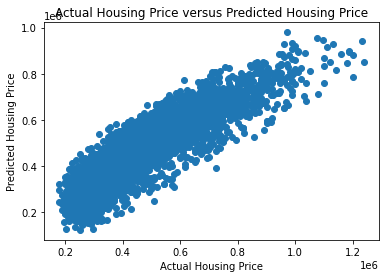

In [22]:
# Import matplotlib library
import matplotlib.pyplot as plt
plt.scatter(y_test_stand, test_predict)
plt.xlabel('Actual Housing Price')
plt.ylabel('Predicted Housing Price')
plt.title('Actual Housing Price versus Predicted Housing Price')
plt.show()

# Experiment 2: Feature Selection

Workflow:
1) Scale the features (min max scaler on whole dataset's features)
2) Split to 80% data for feature selection, 20% reserved for test on selected model
3) Decide a selected model to test, for example KNN* from experiment 1.
4) Select feature subsets using pearson coeff, train & val on KNN*
5) Select feature subsets using SFM with decision tree base model, train & val on KNN*
6) Select feature subsets using RFE on decision tree model, train & val on KNN*

In [1]:
import pandas as pd
df = pd.read_csv('../Data/resale_flat_price_unscaled_20220613.csv')

target = df['resale_price']
features = df.drop('resale_price', axis=1)

In [2]:
# Getting the min max values for each attributes
# The normalize/scaling will be based on these values
min_max_col = pd.DataFrame(['min', 'max'])
pd.concat([min_max_col, pd.DataFrame([features.min(), features.max()])], axis=1)

,0,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,region_central,region_east,region_north,region_north_east,region_west
0,min,0.0,0.0,1.0,0.0,31.0,0.0,30.0,527.0,0.0,0.0,0.0,0.0,0.0
1,max,63.0,6.0,990.0,16.0,199.0,18.0,662.0,1161.0,1.0,1.0,1.0,1.0,1.0


In [3]:
# Perform scaling on the features
from sklearn.preprocessing import MinMaxScaler
features = pd.DataFrame(MinMaxScaler().fit_transform(features), columns=features.columns)

# Split data to train, val, and test
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(features, target, test_size=.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=10)

X, y: to be used in feature selection

X_train, X_val, y_train, y_val: to be used to train & validation the model (during training process)

X_test, y_test: get unbiased score for trained model

In [4]:
# Define print scores method
def get_scores(estimator, X, y, X_val, y_val, X_test, y_test):
    print('Estimator:', estimator)
    estimator.fit(X, y)

    # Validation
    val_pred = estimator.predict(X_val)
    val_r2 = r2_score(y_val, val_pred)
    val_rmse = mean_squared_error(y_val, val_pred, squared=False)
    val_mae = mean_absolute_error(y_val, val_pred)
    print('Validation - R2: {}, RMSE: {}, MAE: {}'.format(val_r2, val_rmse, val_mae))

    # Testing
    test_pred = estimator.predict(X_test)
    test_r2 = r2_score(y_test, test_pred)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    test_mae = mean_absolute_error(y_test, test_pred)
    print('Test - R2: {}, RMSE: {}, MAE: {}'.format(test_r2, test_rmse, test_mae))
    print()

In [5]:
# Use the estimator from Experiment 1
from sklearn.neighbors import KNeighborsRegressor
estimator = KNeighborsRegressor(n_neighbors=3, p=1)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Get the baseline
print('-- Baseline --')
get_scores(estimator, X_train, y_train, X_val, y_val, X_test, y_test)

-- Baseline --
Estimator: KNeighborsRegressor(n_neighbors=3, p=1)
Validation - R2: 0.9093401345410337, RMSE: 47826.0228670242, MAE: 32121.39132777778
Test - R2: 0.9055237149449527, RMSE: 49441.718443406244, MAE: 32302.826844444444



Pearson Coefficient

In [6]:
# Define function for filter based - pearson coefficient (multivariables) method
def pearson(data, target, threshold=.3):
    corr = data.corr()
    corr_target = corr[target]
    corr_selected = corr_target[abs(corr_target) > threshold]
    # Return the indexe of correlation matrix, excl the target itself
    indexer = corr_selected.index[corr_selected.index != target]
    # Put the index str into a list
    return [col for col in indexer]

In [7]:
# To get the coefficient of feature data, merge the features and label
feat_target_df = pd.concat([X,  pd.DataFrame(y, columns=['resale_price'])], axis=1)

# Print the correlation to see the range of correlation
print(abs(feat_target_df.corr()['resale_price']).sort_values())

# Choose suitable threshold parameter to test
thres_set = [0.1, 0.15, 0.2, 0.3, 0.35, 0.4, 0.6]

print('-- Pearson coefficent --')
for thres in thres_set:
    filtered_columns = pearson(feat_target_df, target='resale_price', threshold=thres)

    if (len(filtered_columns) == len(X_train.columns)):
        print('Threshold: {} No column filtered'.format(thres))
        continue

    print('Threshold: {}, selected columns ({}): {}'.format(thres, len(filtered_columns), filtered_columns))

    # Apply the filter on train, val, and test data
    X_train_subset = X_train[filtered_columns]
    X_val_subset = X_val[filtered_columns]
    X_test_subset = X_test[filtered_columns]

    get_scores(estimator, X_train_subset, y_train, X_val_subset, y_val, X_test_subset, y_test)

region_north_east      0.004246
region_east            0.039530
block                  0.100061
region_west            0.113458
month                  0.173323
region_north           0.186391
region_central         0.257067
lease_commence_date    0.338572
remaining_lease        0.338933
storey_range           0.367920
flat_model             0.557059
floor_area_sqm         0.623552
flat_type              0.639508
resale_price           1.000000
Name: resale_price, dtype: float64
-- Pearson coefficent --
Threshold: 0.1, selected columns (11): ['month', 'flat_type', 'block', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'remaining_lease', 'region_central', 'region_north', 'region_west']
Estimator: KNeighborsRegressor(n_neighbors=3, p=1)
Validation - R2: 0.9056048537601097, RMSE: 48801.319405711554, MAE: 32895.38688333334
Test - R2: 0.9012829378783881, RMSE: 50539.188493018315, MAE: 33023.29406666666

Threshold: 0.15, selected columns (9): ['month', 'flat_type', 's

Model-based

In [8]:
from sklearn.feature_selection import SelectFromModel
import numpy as np

def model_based(base_estimator, X, y, threshold='mean'):
    # Get the column names
    columns = X.columns

    selector = SelectFromModel(base_estimator.fit(X, y), threshold=threshold)
    # Get the support, if True, the column is selected
    support = selector.get_support()
    selected_idx = np.where(support == True)
    return [columns[idx] for idx in selected_idx[0]]

In [9]:
# Select a base estimator to build transformer
from sklearn.tree import DecisionTreeRegressor
sfm_model = DecisionTreeRegressor()

# Threshold to test
thres_set = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 'mean', 'median']

print('-- Model based --')
for thres in thres_set:
    filtered_columns = model_based(sfm_model, X, y, threshold=thres)

    if (len(filtered_columns) == len(X_train.columns)):
        print('Threshold: {} No column filtered'.format(thres))
        continue

    print('SelectFromModel using {}, Threshold: {}, selected columns ({}): {}'.format(sfm_model, thres, len(filtered_columns), filtered_columns))

    # Apply the filter on train, val, and test data
    X_train_subset = X_train[filtered_columns]
    X_val_subset = X_val[filtered_columns]
    X_test_subset = X_test[filtered_columns]

    get_scores(estimator, X_train_subset, y_train, X_val_subset, y_val, X_test_subset, y_test)

-- Model based --
SelectFromModel using DecisionTreeRegressor(), Threshold: 0.01, selected columns (9): ['month', 'block', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'remaining_lease', 'region_central', 'region_north']
Estimator: KNeighborsRegressor(n_neighbors=3, p=1)
Validation - R2: 0.874208777780626, RMSE: 56335.467217148296, MAE: 38289.56938333333
Test - R2: 0.8744314825584456, RMSE: 56999.69561610866, MAE: 38074.78721944444

SelectFromModel using DecisionTreeRegressor(), Threshold: 0.02, selected columns (8): ['month', 'block', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'remaining_lease', 'region_central']
Estimator: KNeighborsRegressor(n_neighbors=3, p=1)
Validation - R2: 0.8622646091723234, RMSE: 58949.415715757365, MAE: 40203.11528611111
Test - R2: 0.8596557454282784, RMSE: 60260.0478565686, MAE: 40341.05255277778

SelectFromModel using DecisionTreeRegressor(), Threshold: 0.03, selected columns (8): ['month', 'block', 'st

RFE

In [10]:
from sklearn.feature_selection import RFE

def rfe(estimator, X, y, n_features=None, print_ranking=False):
    # Get the column names
    columns = X.columns
    
    selector = RFE(estimator, n_features_to_select=n_features)
    selector.fit(X, y)

    if print_ranking:
        print('RFE ranking:', selector.ranking_)

    # Get the support, if True, the column is selected
    support = selector.support_
    selected_idx = np.where(support == True)
    return [columns[idx] for idx in selected_idx[0]]

In [11]:
rfe_model = DecisionTreeRegressor()

print('-- RFE --')
for k in range(1, len(X.columns)):
    filtered_columns = rfe(rfe_model, X, y, n_features=k, print_ranking=(k==1))

    print('RFE using {}, Max feature: {}, selected columns ({}): {}'.format(rfe_model, k, len(filtered_columns), filtered_columns))

    # Apply the filter on train, val, and test data
    X_train_subset = X_train[filtered_columns]
    X_val_subset = X_val[filtered_columns]
    X_test_subset = X_test[filtered_columns]

    get_scores(estimator, X_train_subset, y_train, X_val_subset, y_val, X_test_subset, y_test)

-- RFE --
RFE ranking: [ 7 12  5  8  1  2  4  6  3 11  9 13 10]
RFE using DecisionTreeRegressor(), Max feature: 1, selected columns (1): ['floor_area_sqm']
Estimator: KNeighborsRegressor(n_neighbors=3, p=1)
Validation - R2: 0.2504560745295309, RMSE: 137516.6475888636, MAE: 97298.91048611113
Test - R2: 0.22008484073007883, RMSE: 142054.7741820537, MAE: 99213.86821833333

RFE using DecisionTreeRegressor(), Max feature: 2, selected columns (2): ['floor_area_sqm', 'flat_model']
Estimator: KNeighborsRegressor(n_neighbors=3, p=1)
Validation - R2: 0.4926004007043928, RMSE: 113144.06868522319, MAE: 81274.20493055556
Test - R2: 0.48615956970591845, RMSE: 115304.50866463035, MAE: 82409.48605166667

RFE using DecisionTreeRegressor(), Max feature: 3, selected columns (3): ['floor_area_sqm', 'flat_model', 'region_central']
Estimator: KNeighborsRegressor(n_neighbors=3, p=1)
Validation - R2: 0.7118860966124092, RMSE: 85258.7262787971, MAE: 62814.114375
Test - R2: 0.7332596653448589, RMSE: 83076.17624

# Experiment 3: Ensemble Learning

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn import metrics 
from math import sqrt
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('resale_flat_price_unscaled_20220613.csv')

In [3]:
target = df['resale_price']
features = df.drop('resale_price', axis =1)

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(features)
scaled = scaler.fit_transform(features)
features_norm = pd.DataFrame(scaled, columns=features.columns)

In [5]:
from sklearn.model_selection import train_test_split
x_norm, x_test_norm, y_norm, y_test_norm = train_test_split(features_norm, target, test_size = 0.2, random_state = 0)
x_train_norm, x_dev_norm, y_train_norm, y_dev_norm = train_test_split(x_norm, y_norm, test_size = 0.2, random_state =10)

## Stacking

In [6]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

In [7]:
def get_stacking():
    level0 = list()
    level0.append(('knn', KNeighborsRegressor(n_neighbors= 3, p=1)))
    level0.append(('dtree', DecisionTreeRegressor(max_depth = 16)))

    level1 = LinearRegression()

    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
 

def get_models():
    models = dict()
    models['knn'] = KNeighborsRegressor(n_neighbors= 3, p=1)
    models['dtree'] = DecisionTreeRegressor(max_depth = 16)
    models['stacking'] = get_stacking()
    return models
 
models = get_models()
results, names = list(), list()

In [9]:
for name, model in models.items():
   model.fit(x_train_norm, y_train_norm)
   val_predict = model.predict(x_dev_norm)
   #val_predict = val_predict.reshape(len(test_predict), 1)
   
   print("%s - R2 (Val): " % (name), r2_score(y_dev_norm, val_predict))
   print("%s - RMSE (Val): " % (name), sqrt(metrics.mean_squared_error(y_dev_norm, val_predict)))
   print("%s - MAE (Val): " % (name), metrics.mean_absolute_error(y_dev_norm, val_predict))

knn - R2 (Val):  0.9093389923429103
knn - RMSE (Val):  47826.324139374636
knn - MAE (Val):  32123.860216666664
dtree - R2 (Val):  0.8784520909633866
dtree - RMSE (Val):  55377.134345916405
dtree - MAE (Val):  35042.39450731005
stacking - R2 (Val):  0.9200003064710247
stacking - RMSE (Val):  44926.32491511168
stacking - MAE (Val):  30024.102024337866


In [10]:
level0 = list()
level0.append(('knn', KNeighborsRegressor(n_neighbors= 3, p=1)))
level0.append(('dtree', DecisionTreeRegressor(max_depth = 16)))

level1 = LinearRegression()

model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
model.fit(x_norm, y_norm)
test_predict = model.predict(x_test_norm)
print("R2 (Test): ", r2_score(y_test_norm, test_predict))
print("RMSE (Test): ", sqrt(metrics.mean_squared_error(y_test_norm, test_predict)))
print("MAE (Test): ", metrics.mean_absolute_error(y_test_norm, test_predict))


R2 (Test):  0.9251264157542614
RMSE (Test):  44014.57016032615
MAE (Test):  28984.85105550299


## Blending

In [11]:
from numpy import hstack

def get_models():
    models = list()
    models.append(('lr', LinearRegression()))
    models.append(('knn', KNeighborsRegressor()))
    models.append(('dtree', DecisionTreeRegressor()))
    return models

def fit_ensemble(models, x_train, x_dev, y_train, y_dev):
    meta_x = list()
    for name, model in models:
        model.fit(x_train, y_train)
        test_predict = model.predict(x_dev)
        test_predict = test_predict.reshape(len(test_predict), 1)
        meta_x.append(test_predict)

    meta_x = hstack(meta_x)
    blender = LinearRegression()
    blender.fit(meta_x, y_dev)
    
    print("R2 (Val): ", r2_score(y_dev, test_predict))
    print("RMSE (Val): ", sqrt(metrics.mean_squared_error(y_dev, test_predict)))
    print("MAE (Val): ", metrics.mean_absolute_error(y_dev, test_predict))
    return blender
 
def predict_ensemble(models, blender, x_test):
    meta_x = list()
    for name, model in models:
        test_predict = model.predict(x_test)
        test_predict = test_predict.reshape(len(test_predict), 1)
        meta_x.append(test_predict)

    meta_x = hstack(meta_x)
    return blender.predict(meta_x)

In [12]:
models = get_models()
blender = fit_ensemble(models, x_train_norm, x_dev_norm, y_train_norm, y_dev_norm)
test_predict_blend = predict_ensemble(models, blender, x_test_norm)

print("R2 (Test): ", r2_score(y_test_norm, test_predict_blend))
print("RMSE (Test): ", sqrt(metrics.mean_squared_error(y_test_norm, test_predict_blend)))
print("MAE (Test): ", metrics.mean_absolute_error(y_test_norm, test_predict_blend))

R2 (Val):  0.8680213103946963
RMSE (Val):  57704.36125352839
MAE (Val):  34522.667291666665
R2 (Test):  0.9098343263827348
RMSE (Test):  48300.6270577587
MAE (Test):  31801.878585287937


## Boosting - XGBoost

In [13]:
from numpy import absolute
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

In [14]:
model = XGBRegressor()
model.fit(x_train_norm, y_train_norm)
val_predict_boost = model.predict(x_dev_norm)
print("R2 (Val): ", r2_score(y_dev_norm, val_predict_boost))
print("RMSE (Val): ", sqrt(metrics.mean_squared_error(y_dev_norm, val_predict_boost)))
print("MAE (Val): ", metrics.mean_absolute_error(y_dev_norm, val_predict_boost))

R2 (Val):  0.9387447227898447
RMSE (Val):  39312.30303381723
MAE (Val):  27219.183235677083


In [15]:
model.fit(x_norm, y_norm)
test_predict_boost = model.predict(x_test_norm)
print("R2 (Test): ", r2_score(y_test_norm, test_predict_boost))
print("RMSE (Test): ", sqrt(metrics.mean_squared_error(y_test_norm, test_predict_boost)))
print("MAE (Test): ", metrics.mean_absolute_error(y_test_norm, test_predict_boost))

R2 (Test):  0.9397627931540915
RMSE (Test):  39478.85660446652
MAE (Test):  27434.4757409375


# Experiment 4: Varying training data size

## Data

In [1]:
import pandas as pd
df = pd.read_csv('../Data/resale_flat_price_unscaled_20220613.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                30000 non-null  int64  
 1   flat_type            30000 non-null  int64  
 2   block                30000 non-null  int64  
 3   storey_range         30000 non-null  int64  
 4   floor_area_sqm       30000 non-null  float64
 5   flat_model           30000 non-null  int64  
 6   lease_commence_date  30000 non-null  int64  
 7   remaining_lease      30000 non-null  int64  
 8   resale_price         30000 non-null  float64
 9   region_central       30000 non-null  int64  
 10  region_east          30000 non-null  int64  
 11  region_north         30000 non-null  int64  
 12  region_north_east    30000 non-null  int64  
 13  region_west          30000 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 3.2 MB


In [2]:
target = df['resale_price']
features = df.drop('resale_price', axis=1)

In [3]:
from sklearn.preprocessing import MinMaxScaler
features = pd.DataFrame(MinMaxScaler().fit_transform(features), columns=features.columns)

In [4]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(features, target, test_size=.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=10)

## Methods and variables for the experiment

In [5]:
import numpy as np

def gen_incremental_subsample(X, y, start_percent=10, increment_percent=10, end_percent=100, random=True):
    # Start from remaining whole dataset
    X_rem = X
    y_rem = y

    # Data to be returned
    X_part = pd.DataFrame(columns=X.columns, dtype=np.float64)
    y_part = pd.Series(dtype=np.float64)

    # Calculate the increment data size
    part_size = int(len(X) * increment_percent / 100.)

    percent = start_percent
    while percent <= end_percent:
        if random:
            if (percent == 100):
                # Get the remaining portion
                X_add, y_add = X_rem, y_rem
            else:
                # Random subsample another portion from the remaining
                X_add, X_rem, y_add, y_rem = train_test_split(X_rem, y_rem, train_size=part_size,\
                    random_state=int(percent))

            # Concat the additional portion to the data to be returned
            X_part = pd.concat([X_part, X_add], axis=0)
            y_part = pd.concat([y_part, y_add], axis=0)
        else:
            # Increment return without further random subsample
            X_part = X[:int(len(X) * percent / 100.)]
            y_part = y[:int(len(y) * percent / 100.)]

        yield (percent, X_part, y_part)
        percent = percent + increment_percent

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_experiment(estimator, random=True):
    global X_train, y_train, X_val, y_val, X_test, y_test

    result = {}
    result['train_percent'] = []
    result['val_r2'] = []
    result['val_rmse'] = []
    result['val_mae'] = []
    result['test_r2'] = []
    result['test_rmse'] = []
    result['test_mae'] = []

    for percent, X_train_part, y_train_part in gen_incremental_subsample(X_train, y_train, increment_percent=10, random=random):
        estimator.fit(X_train_part, y_train_part)

        val_pred = estimator.predict(X_val)
        test_pred = estimator.predict(X_test)

        result['train_percent'].append(percent)
        result['val_r2'].append(r2_score(y_val, val_pred))
        result['val_rmse'].append(mean_squared_error(y_val, val_pred, squared=False))
        result['val_mae'].append(mean_absolute_error(y_val, val_pred))
        result['test_r2'].append(r2_score(y_test, test_pred))
        result['test_rmse'].append(mean_squared_error(y_test, test_pred, squared=False))
        result['test_mae'].append(mean_absolute_error(y_test, test_pred))
    return result 

In [7]:
def print_result_scores(result):
    print('Validation R^2:', result['val_r2'])
    print('Validation RMSE:', result['val_rmse'])
    print('Validation MAE:', result['val_mae'])
    print()
    print('Test R^2:', result['test_r2'])
    print('Test RMSE:', result['test_rmse'])
    print('Test MAE:', result['test_mae'])

In [8]:
import matplotlib.pyplot as plt

def plot_result_scores(result):
    plt.subplots(1, 3, figsize=(20,5))

    plt.subplot(1, 3, 1)
    plt.plot(result['train_percent'], result['val_r2'], c='C0', label='Validation')
    plt.plot(result['train_percent'], result['test_r2'], c='C1', label='Testing')
    plt.title('R^2 Scores')
    plt.xlabel('Train Data %')
    plt.ylabel('R^2 Score')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.plot(result['train_percent'], result['val_rmse'], c='C0', label='Validation')
    plt.plot(result['train_percent'], result['test_rmse'], c='C1', label='Testing')
    plt.title('RMSE')
    plt.xlabel('Train Data %')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 3, 3)
    plt.plot(result['train_percent'], result['val_mae'], c='C0', label='Validation')
    plt.plot(result['train_percent'], result['test_mae'], c='C1', label='Testing')
    plt.title('MAE')
    plt.xlabel('Train Data %')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid()

In [9]:
def to_csv(result, file_path):
    with open(file_path, 'w') as file:
        text = ''
        for key in result:
            text = text + key + ','
        text = text + '\n'
        for i in range(len(result['train_percent'])):
            text = text + str(result['train_percent'][i]) + ','
            text = text + str(result['val_r2'][i]) + ','
            text = text + str(result['val_rmse'][i]) + ','
            text = text + str(result['val_mae'][i]) + ','
            text = text + str(result['test_r2'][i]) + ','
            text = text + str(result['test_rmse'][i]) + ','
            text = text + str(result['test_mae'][i]) + ','
            text = text + '\n'
        file.write(text)

In [10]:
results = {}

## Boosting - [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)

In [11]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

results['xgboost'] = run_experiment(xgb)
print_result_scores(results['xgboost'])

Validation R^2: [0.8702777004125313, 0.8999025678048733, 0.9074779312783605, 0.916923009718471, 0.9236053363624007, 0.9250524631323643, 0.9303531036646059, 0.9343243296233329, 0.9357182801097457, 0.9387447227898447]
Validation RMSE: [57208.9598215255, 50253.71823128618, 48314.71247942579, 45782.24754791829, 43902.398103171094, 43484.593468543, 41918.68168807697, 40706.05258520579, 40271.747577198425, 39312.30303381723]
Validation MAE: [39484.99202799479, 34222.65354492187, 32814.765852864584, 31541.89845377604, 30081.708193359376, 29575.44109375, 28818.0138671875, 28380.433860677083, 27882.142041015624, 27219.183235677083]

Test R^2: [0.8729252740286348, 0.8993774701194976, 0.9069085083824582, 0.9164521104822503, 0.9237770604582795, 0.9273902102880518, 0.9304996576157476, 0.9334700468725372, 0.9349037419593792, 0.9379795520396603]
Test RMSE: [57340.535448870134, 51024.61885682793, 49078.032935316885, 46494.319433338125, 44409.40963596466, 43344.07534871088, 42405.835588699294, 41489.74

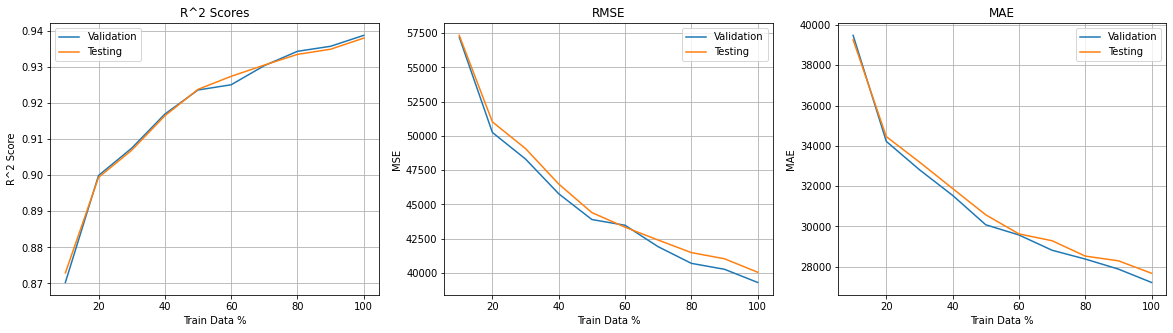

In [12]:
plot_result_scores(results['xgboost'])

In [13]:
to_csv(results['xgboost'], 'temp_xgboost_result.csv')

## Stacking:

Base models

Level 0:
- kNN (k=3, p=1)
- Decision tree (max depth=16)

Level 1:
- Linear regression


In [14]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

level_0 = list()
level_0.append(('knn', KNeighborsRegressor(n_neighbors=3, p=1)))
level_0.append(('dtree', DecisionTreeRegressor(max_depth=16)))
level_1 = LinearRegression()

sr = StackingRegressor(level_0, level_1, cv=5)
results['stacking'] = run_experiment(sr)
print_result_scores(results['stacking'])

Validation R^2: [0.839801755990389, 0.8675921849363442, 0.8823521968002541, 0.8911746084353858, 0.8964573634856206, 0.907402214093823, 0.9102076441301612, 0.9147471470668601, 0.916335885241792, 0.920894189898124]
Validation RMSE: [63574.88857956916, 57798.09727489431, 54481.448181920314, 52398.86154384957, 51111.23108681872, 48334.47806566362, 47596.653108885956, 46377.91205540906, 45943.73963813777, 44674.625775019704]
Validation MAE: [43732.28202020233, 39476.16035972788, 36970.58004317234, 35383.49943114142, 34127.13177572482, 32517.19117814134, 31801.21924986649, 31021.338611197323, 30908.273982075247, 29994.775320340657]

Test R^2: [0.84472534439364, 0.8720722608370224, 0.8810849049611763, 0.8916897399142648, 0.8953245646736058, 0.9042963617992402, 0.9063082552360173, 0.9115515118862145, 0.9147351892890658, 0.9159612919553615]
Test RMSE: [63384.40830075605, 57532.66816435694, 55469.03964116301, 52937.92965654929, 52042.06742499747, 49761.83388394381, 49236.00606169469, 47838.47867

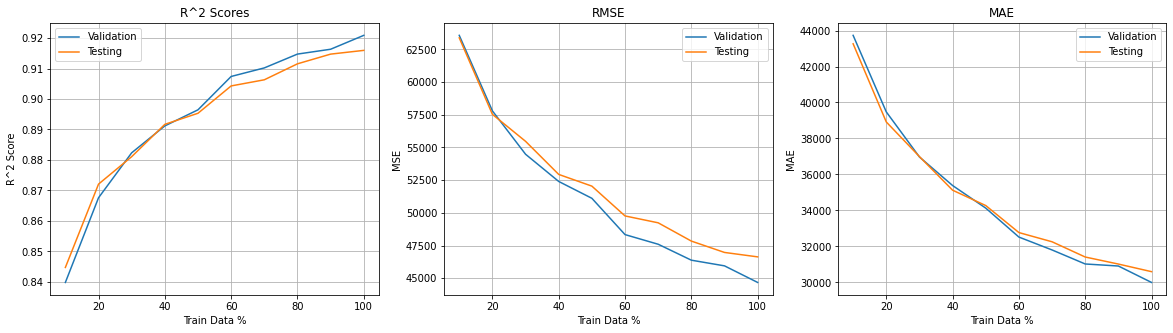

In [15]:
plot_result_scores(results['stacking'])

In [16]:
to_csv(results['stacking'], 'temp_stacking_result.csv')

## kNN

k=3, p=1 (Manhattan distance)

In [17]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3, p=1)
results['knn'] = run_experiment(knn)
print_result_scores(results['knn'])

Validation R^2: [0.8208250854242909, 0.8521211203822103, 0.8676968857939433, 0.8771276726690115, 0.8822369730301887, 0.8913089777273419, 0.8962475980549891, 0.9021394571835768, 0.9049498765875854, 0.9093345535440045]
Validation RMSE: [67234.98852554754, 61081.51605979228, 57775.240968703336, 55678.01891773231, 54508.121104772086, 52366.50249360162, 51162.97761940143, 49689.032684169724, 48970.33495624844, 47827.49492294709]
Validation MAE: [46592.694861111115, 41677.182291666664, 39143.620208333334, 37590.78104166667, 36620.74111111111, 35094.411875, 34403.3498, 33426.02861944444, 32946.563550000006, 32125.982438888885]

Test R^2: [0.8250864869034323, 0.8533444592010775, 0.8683188638030265, 0.8782564036833452, 0.8828278401379726, 0.8878346374694692, 0.891435710945587, 0.8964388476364745, 0.900824855886511, 0.9055177744856324]
Test RMSE: [67273.47078466564, 61600.09629014336, 58370.57019400211, 56124.85299951022, 55061.035023721815, 53871.80603267653, 52999.97314097083, 51764.3291838821

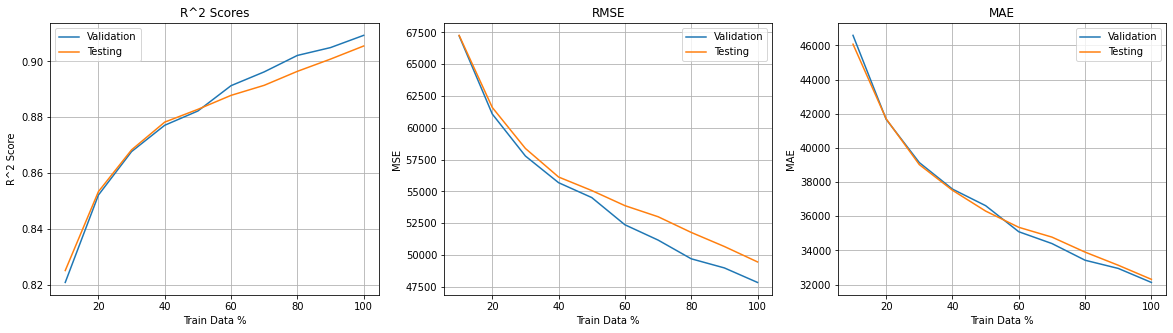

In [18]:
plot_result_scores(results['knn'])

In [19]:
to_csv(results['knn'], 'temp_knn_result.csv')

## Blending

Base models: Linear Regression, kNN, Decision Tree

Meta models: Linear Regression


In [26]:
from numpy import hstack

class CustomBlendingRegressor:
    def __init__(self, blender, base_estimators):
        self.blender = blender
        self.models = []
        for estimator in base_estimators:
            self.models.append(estimator)

    def fit(self, X, y):
        # Split to train data to new train data & holdout data
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=10)

        # Get predictions from base models
        meta_X = []
        for model in self.models:
            model.fit(X_train, y_train)
            pred = model.predict(X_holdout)
            pred = pred.reshape(len(pred), 1)
            meta_X.append(pred)
        meta_X = hstack(meta_X)

        # Fit the estimation to blender
        self.blender.fit(meta_X, y_holdout)

    def predict(self, X):
        meta_X = []
        for model in self.models:
            pred = model.predict(X)
            pred = pred.reshape(len(pred), 1)
            meta_X.append(pred)
        meta_X = hstack(meta_X)
        return self.blender.predict(meta_X)

In [27]:
blender = CustomBlendingRegressor(blender=LinearRegression(),\
    base_estimators=[LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor()])
results['blending'] = run_experiment(blender)
print_result_scores(results['blending'])

Validation R^2: [0.8339377209356909, 0.8570067547775828, 0.8737028634048937, 0.8773599994134308, 0.8840885284322708, 0.8933251707658952, 0.8970764971479986, 0.9007169188918958, 0.9047686863765967, 0.908038246193654]
Validation RMSE: [64728.00609037548, 60064.03352298064, 56448.64015181621, 55625.356070285656, 54077.91537088466, 51878.53579802789, 50958.19205091427, 50048.87908110389, 49016.98781947334, 48168.19303137676]
Validation MAE: [45932.02412581866, 41981.38050520562, 39099.897459837244, 38095.95811371252, 36335.464148825406, 34941.515805082876, 34400.83286753226, 33733.64490421324, 32775.65496618905, 32165.023290555342]

Test R^2: [0.8400138749336661, 0.8598656261222516, 0.8743603688574486, 0.8781447868365622, 0.8876120143453309, 0.8914850939543248, 0.8956129121697062, 0.8992270189686913, 0.9062403504726808, 0.9091817656527243]
Test RMSE: [64338.85281897484, 60214.97243576957, 57015.83375986154, 56150.575272043876, 53925.24126651609, 52987.917630535194, 51970.338330338534, 5106

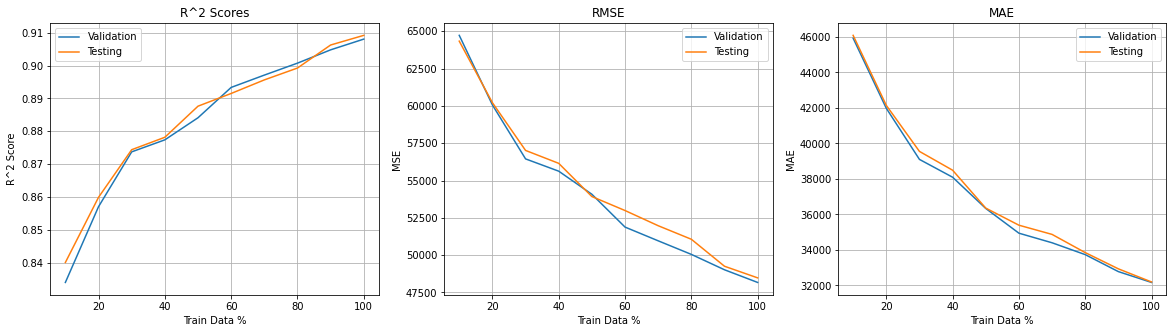

In [28]:
plot_result_scores(results['blending'])

In [29]:
to_csv(results['blending'], 'temp_blending_result.csv')